In [1]:
import os
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import natsort

# colorblind-friendly colors
CB_palette = ['#377eb8', '#ff7f00', '#4daf4a',
                '#f781bf', '#a65628', '#984ea3',
                '#999999', '#e41a1c', '#dede00']

## Back-end functions

In [2]:
# Threshold-based classification
def load_data(folder_path, exclude=None): 
    """
    Load and concatenate data from CSV files in the specified folder, excluding a given file if specified.

    Parameters:
    - folder_path (str): Path to the folder containing the CSV files.
    - exclude_filename (str, optional): Name of the file to exclude from loading.

    Returns:
    - DataFrame: Concatenated DataFrame containing data from all included CSV files.
    """
    # Get a list of all CSV files in the folder
    file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

    # Exclude the specified file
    if exclude:
        file_paths = [fp for fp in file_paths if exclude not in fp]

    file_paths = natsort.natsorted(file_paths)

    # Specify the columns you want to load
    columns_to_load = ['Classification', 
                    'Object ID', 
                    'DAPI: Nucleus: Median', 
                    'KER_488: Cytoplasm: Median', 
                    'KI67_647: Nucleus: Max']

    all = []

    for file_path in file_paths:
        df = pd.read_csv(file_path, usecols=columns_to_load)
        print(f"Cell count: {len(df)}")
        # df_ker488_pndrg1_647 = df[df['Classification'] == 'KER_488: pNDRG1_647']  # Filter rows by 'Class' for KER_488: pNDRG1_647
        # df_ker488 = df[df['Classification'] == 'KER_488']  # Filter rows by 'Class' for KER_488
        # dfs_ker488_pndrg1_647.append(df_ker488_pndrg1_647)
        # dfs_ker488.append(df_ker488)
        all.append(df)

    # Concatenate all filtered datasets
    # ker_pndrg_data_thr = pd.concat(dfs_ker488_pndrg1_647, ignore_index=True)
    # ker_data_thr = pd.concat(dfs_ker488, ignore_index=True)
    all_df = pd.concat(all, ignore_index=True)

    return all_df

## Compare classification results between ML and thresholds

### Thresholds vs ML all features

In [52]:
folder_thr = "/Users/antoine/Harvard/IAC/NinaKozlova/20240425_SW1990_Ki67/Results/ML_classifier/20240613_threshold_ki67_nucleus_max"
thr_label = load_data(folder_thr)

folder_ML = "/Users/antoine/Harvard/IAC/NinaKozlova/20240425_SW1990_Ki67/Results/ML_classifier/20240613_ML_all_features"
ML_all = load_data(folder_ML)

# Count how many 'Object ID' cells are common between the two datasets
common_object_ids = len(set(ML_all['Object ID']).intersection(set(thr_label['Object ID'])))
print("Number of common Object IDs between the two datasets:", common_object_ids)

flag = (len(set(ML_all['Object ID'])) == len(set(thr_label['Object ID'])))
print("Datasets have the same number of cells:", flag)

# Create a lookup table for class name conversion
class_lookup_ML = {
    'KER+: KI67+': 'KI67+: KER+',
    'KER+: KI67-': 'KI67-: KER+',
    'KER-: KI67-': 'KI67-: KER-',
    'KER-: KI67+': 'KI67+: KER-',
    'KI67+: KER+': 'KI67+: KER+',
    'KI67+: KER-': 'KI67+: KER-',
    'KI67-: KER+': 'KI67-: KER+',
    'KI67-: KER-': 'KI67-: KER-'
}

# Apply the lookup table to the 'Classification' column in ML_all
ML_all['Classification'] = ML_all['Classification'].map(class_lookup_ML)


# Create a lookup table for class name conversion in thr_label
class_lookup = {
    'KER_488: KI67_647': 'KI67+: KER+',
    'KER_488': 'KI67-: KER+',
    'KI67_647': 'KI67+: KER-',
}

# Apply the lookup table to the 'Classification' column in thr_label
thr_label['Classification'] = thr_label['Classification'].map(class_lookup)

# Handle any remaining NaN values explicitly
thr_label['Classification'] = thr_label['Classification'].fillna('KI67-: KER-')

# Verify that there are no NaN values in the 'Classification' column after mapping
nan_count = thr_label['Classification'].isna().sum()
print("Number of NaN values in 'Classification' column after mapping:", nan_count)

Cell count: 272961
Cell count: 95389
Cell count: 154157
Cell count: 306898
Cell count: 58254
Cell count: 80063
Cell count: 91509
Cell count: 99662
Cell count: 272961
Cell count: 95389
Cell count: 154157
Cell count: 306898
Cell count: 58254
Cell count: 80063
Cell count: 91509
Cell count: 99662
Number of common Object IDs between the two datasets: 1158893
Datasets have the same number of cells: True
Number of NaN values in 'Classification' column after mapping: 0


True Class: KI67+: KER+
Predicted Class: KI67+: KER+, Count: 161822
Predicted Class: KI67-: KER+, Count: 16899
Predicted Class: KI67+: KER-, Count: 356
Predicted Class: KI67-: KER-, Count: 39

True Class: KI67-: KER+
Predicted Class: KI67+: KER+, Count: 27990
Predicted Class: KI67-: KER+, Count: 883176
Predicted Class: KI67+: KER-, Count: 72
Predicted Class: KI67-: KER-, Count: 1711

True Class: KI67+: KER-
Predicted Class: KI67+: KER+, Count: 815
Predicted Class: KI67-: KER+, Count: 35
Predicted Class: KI67+: KER-, Count: 926
Predicted Class: KI67-: KER-, Count: 114

True Class: KI67-: KER-
Predicted Class: KI67+: KER+, Count: 504
Predicted Class: KI67-: KER+, Count: 46105
Predicted Class: KI67+: KER-, Count: 345
Predicted Class: KI67-: KER-, Count: 17984

Ratio of agreement between the two methods: 91.80381622807282


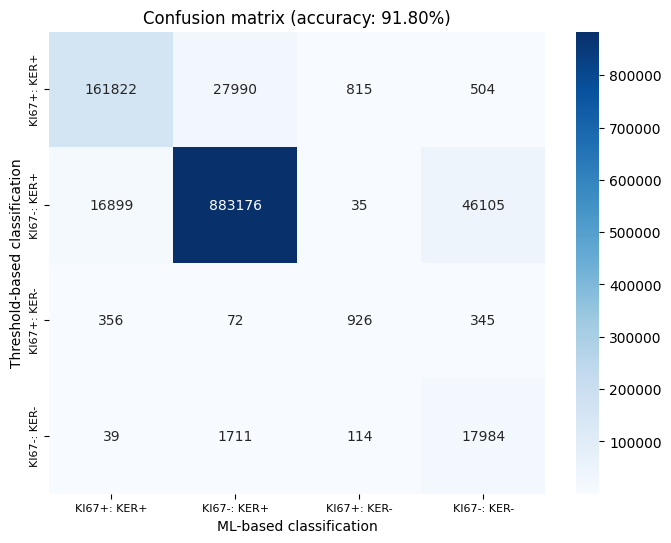

In [53]:
# Merge the datasets on the 'Object ID' column
merged_data = pd.merge(ML_all, thr_label, on='Object ID', suffixes=('_ML', '_Thr'))

# Get common 'Object ID' cells between the two datasets
common_object_ids = set(ML_all['Object ID']).intersection(set(thr_label['Object ID']))

# Filter the merged data to include only common 'Object ID' cells
merged_data_common = merged_data[merged_data['Object ID'].isin(common_object_ids)]

# Initialize counts for each class combination
class_counts = {
    'KI67+: KER+': {'KI67+: KER+': 0, 'KI67-: KER+': 0, 'KI67+: KER-': 0, 'KI67-: KER-': 0},
    'KI67-: KER+': {'KI67+: KER+': 0, 'KI67-: KER+': 0, 'KI67+: KER-': 0, 'KI67-: KER-': 0},
    'KI67+: KER-': {'KI67+: KER+': 0, 'KI67-: KER+': 0, 'KI67+: KER-': 0, 'KI67-: KER-': 0},
    'KI67-: KER-': {'KI67+: KER+': 0, 'KI67-: KER+': 0, 'KI67+: KER-': 0, 'KI67-: KER-': 0}
}

# Iterate through the merged data and count occurrences of each class combination
for _, row in merged_data_common.iterrows():
    class_counts[row['Classification_ML']][row['Classification_Thr']] += 1

# Print the class counts
for true_class, predicted_classes in class_counts.items():
    print(f'True Class: {true_class}')
    for predicted_class, count in predicted_classes.items():
        print(f'Predicted Class: {predicted_class}, Count: {count}')
    print()

# Define class labels
classes = ['KI67+: KER+', 'KI67-: KER+', 'KI67+: KER-', 'KI67-: KER-']
#classes = ['KER+: pNDRG1+', 'KER+: pNDRG1-', 'KER-: pNDRG1+', 'KER-: pNDRG1-']

# Create a DataFrame from class counts dictionary
confusion_df = pd.DataFrame(class_counts, index=classes)

# Sum up counts along the diagonal (correct predictions)
correct_predictions = np.diag(confusion_df)

# Total number of samples
total_samples = confusion_df.values.sum()

# Calculate ratio of agreement
agreement_ratio = (correct_predictions.sum() / total_samples) * 100

print("Ratio of agreement between the two methods:", agreement_ratio)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion matrix (accuracy: {agreement_ratio:.2f}%)')
plt.ylabel('Threshold-based classification')
plt.xlabel('ML-based classification')
plt.tick_params(axis='both', which='major', labelsize=8)  # Change 12 to your desired font size
plt.show()

True Class: KI67+: KER+
Predicted Class: KI67+: KER+, Count: 161822
Predicted Class: KI67-: KER+, Count: 16899

True Class: KI67-: KER+
Predicted Class: KI67+: KER+, Count: 27990
Predicted Class: KI67-: KER+, Count: 883176

Ratio of agreement between the two methods: 95.8813161364435


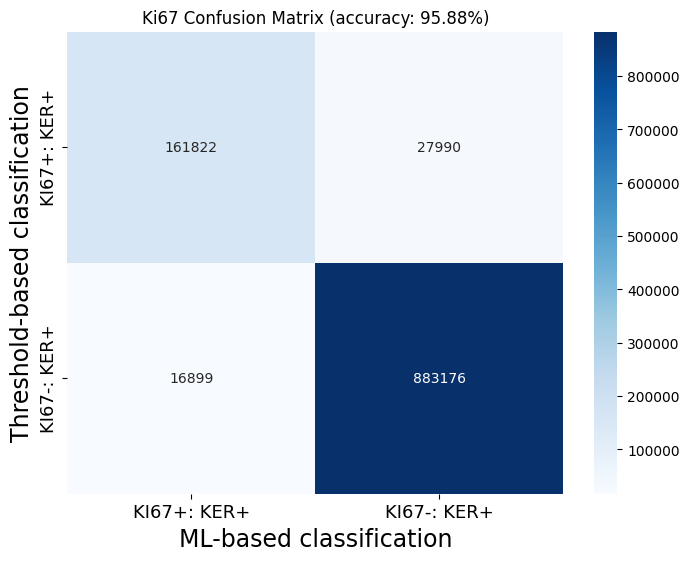

In [58]:
all_thr_subset = thr_label[thr_label['Classification'].isin(['KI67+: KER+', 'KI67-: KER+'])]
all_ML_subset = ML_all[ML_all['Classification'].isin(['KI67+: KER+', 'KI67-: KER+'])]

# Merge the datasets on the 'Object ID' column
merged_data = pd.merge(all_ML_subset, all_thr_subset, on='Object ID', suffixes=('_ML', '_Thr'))

# Get common 'Object ID' cells between the two datasets
common_object_ids = set(all_ML_subset['Object ID']).intersection(set(all_thr_subset['Object ID']))

# Filter the merged data to include only common 'Object ID' cells
merged_data_common = merged_data[merged_data['Object ID'].isin(common_object_ids)]

# Initialize counts for each class combination
class_counts = {
    'KI67+: KER+': {'KI67+: KER+': 0, 'KI67-: KER+': 0},
    'KI67-: KER+': {'KI67+: KER+': 0, 'KI67-: KER+': 0},
}

# Iterate through the merged data and count occurrences of each class combination
for _, row in merged_data_common.iterrows():
    class_counts[row['Classification_ML']][row['Classification_Thr']] += 1

# Print the class counts
for true_class, predicted_classes in class_counts.items():
    print(f'True Class: {true_class}')
    for predicted_class, count in predicted_classes.items():
        print(f'Predicted Class: {predicted_class}, Count: {count}')
    print()

# Define class labels
classes = ['KI67+: KER+', 'KI67-: KER+']
#classes = ['KER+: pNDRG1+', 'KER+: pNDRG1-', 'KER-: pNDRG1+', 'KER-: pNDRG1-']

# Create a DataFrame from class counts dictionary
confusion_df = pd.DataFrame(class_counts, index=classes)

# Sum up counts along the diagonal (correct predictions)
correct_predictions = np.diag(confusion_df)

# Total number of samples
total_samples = confusion_df.values.sum()

# Calculate ratio of agreement
agreement_ratio = (correct_predictions.sum() / total_samples) * 100

print("Ratio of agreement between the two methods:", agreement_ratio)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues')
plt.title(f'Ki67 Confusion Matrix (accuracy: {agreement_ratio:.2f}%)')
plt.ylabel('Threshold-based classification', fontsize=17)
plt.xlabel('ML-based classification', fontsize=17)
plt.tick_params(axis='both', which='major', labelsize=13)  # Change 12 to your desired font size
plt.savefig("/Users/antoine/Harvard/IAC/NinaKozlova/Submission/Supplementary/figures/Ki67_confusion_matrix_all_features.png", dpi=300)
plt.show()

### Thresholds vs ML intensity features

In [6]:
folder_thr = "/Users/antoine/Harvard/IAC/NinaKozlova/20240425_SW1990_Ki67/Results/ML_classifier/20240613_threshold_ki67_nucleus_max"
thr_label = load_data(folder_thr)

# folder_ML = "/Users/antoine/Harvard/IAC/NinaKozlova/20240425_SW1990_Ki67/Results/ML_classifier/20240613_ML_intensity_features"
folder_ML = "/Users/antoine/Harvard/IAC/NinaKozlova/20240425_SW1990_Ki67/Results/ML_classifier/20240620_ML_intensity_features_normalized"
ML_all = load_data(folder_ML)

# Count how many 'Object ID' cells are common between the two datasets
common_object_ids = len(set(ML_all['Object ID']).intersection(set(thr_label['Object ID'])))
print("Number of common Object IDs between the two datasets:", common_object_ids)

flag = (len(set(ML_all['Object ID'])) == len(set(thr_label['Object ID'])))
print("Datasets have the same number of cells:", flag)

# Create a lookup table for class name conversion
class_lookup_ML = {
    'KER+: KI67+': 'KI67+: KER+',
    'KER+: KI67-': 'KI67-: KER+',
    'KER-: KI67-': 'KI67-: KER-',
    'KER-: KI67+': 'KI67+: KER-',
    'KI67+: KER+': 'KI67+: KER+',
    'KI67+: KER-': 'KI67+: KER-',
    'KI67-: KER+': 'KI67-: KER+',
    'KI67-: KER-': 'KI67-: KER-'
}

# Apply the lookup table to the 'Classification' column in ML_all
ML_all['Classification'] = ML_all['Classification'].map(class_lookup_ML)


# Create a lookup table for class name conversion in thr_label
class_lookup = {
    'KER_488: KI67_647': 'KI67+: KER+',
    'KER_488': 'KI67-: KER+',
    'KI67_647': 'KI67+: KER-',
}

# Apply the lookup table to the 'Classification' column in thr_label
thr_label['Classification'] = thr_label['Classification'].map(class_lookup)

# Handle any remaining NaN values explicitly
thr_label['Classification'] = thr_label['Classification'].fillna('KI67-: KER-')

# Verify that there are no NaN values in the 'Classification' column after mapping
nan_count = thr_label['Classification'].isna().sum()
print("Number of NaN values in 'Classification' column after mapping:", nan_count)

Cell count: 272961
Cell count: 95389
Cell count: 154157
Cell count: 306898
Cell count: 58254
Cell count: 80063
Cell count: 91509
Cell count: 99662
Cell count: 272961
Cell count: 95389
Cell count: 154157
Cell count: 306898
Cell count: 58254
Cell count: 80063
Cell count: 91509
Cell count: 99662
Number of common Object IDs between the two datasets: 1158893
Datasets have the same number of cells: True
Number of NaN values in 'Classification' column after mapping: 0


True Class: KI67+: KER+
Predicted Class: KI67+: KER+, Count: 162970
Predicted Class: KI67-: KER+, Count: 29330
Predicted Class: KI67+: KER-, Count: 142
Predicted Class: KI67-: KER-, Count: 80

True Class: KI67-: KER+
Predicted Class: KI67+: KER+, Count: 22055
Predicted Class: KI67-: KER+, Count: 852690
Predicted Class: KI67+: KER-, Count: 15
Predicted Class: KI67-: KER-, Count: 1985

True Class: KI67+: KER-
Predicted Class: KI67+: KER+, Count: 5099
Predicted Class: KI67-: KER+, Count: 1438
Predicted Class: KI67+: KER-, Count: 1387
Predicted Class: KI67-: KER-, Count: 1165

True Class: KI67-: KER-
Predicted Class: KI67+: KER+, Count: 1007
Predicted Class: KI67-: KER+, Count: 62757
Predicted Class: KI67+: KER-, Count: 155
Predicted Class: KI67-: KER-, Count: 16618

Ratio of agreement between the two methods: 89.1941706438817


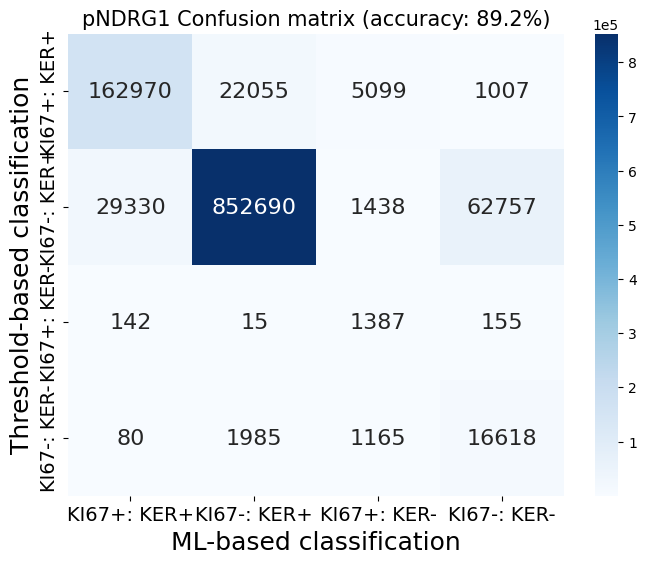

In [7]:
# Merge the datasets on the 'Object ID' column
merged_data = pd.merge(ML_all, thr_label, on='Object ID', suffixes=('_ML', '_Thr'))

# Get common 'Object ID' cells between the two datasets
common_object_ids = set(ML_all['Object ID']).intersection(set(thr_label['Object ID']))

# Filter the merged data to include only common 'Object ID' cells
merged_data_common = merged_data[merged_data['Object ID'].isin(common_object_ids)]

# Initialize counts for each class combination
class_counts = {
    'KI67+: KER+': {'KI67+: KER+': 0, 'KI67-: KER+': 0, 'KI67+: KER-': 0, 'KI67-: KER-': 0},
    'KI67-: KER+': {'KI67+: KER+': 0, 'KI67-: KER+': 0, 'KI67+: KER-': 0, 'KI67-: KER-': 0},
    'KI67+: KER-': {'KI67+: KER+': 0, 'KI67-: KER+': 0, 'KI67+: KER-': 0, 'KI67-: KER-': 0},
    'KI67-: KER-': {'KI67+: KER+': 0, 'KI67-: KER+': 0, 'KI67+: KER-': 0, 'KI67-: KER-': 0}
}

# Iterate through the merged data and count occurrences of each class combination
for _, row in merged_data_common.iterrows():
    class_counts[row['Classification_ML']][row['Classification_Thr']] += 1

# Print the class counts
for true_class, predicted_classes in class_counts.items():
    print(f'True Class: {true_class}')
    for predicted_class, count in predicted_classes.items():
        print(f'Predicted Class: {predicted_class}, Count: {count}')
    print()

# Define class labels
classes = ['KI67+: KER+', 'KI67-: KER+', 'KI67+: KER-', 'KI67-: KER-']
#classes = ['KER+: pNDRG1+', 'KER+: pNDRG1-', 'KER-: pNDRG1+', 'KER-: pNDRG1-']

# Create a DataFrame from class counts dictionary
confusion_df = pd.DataFrame(class_counts, index=classes)

# Sum up counts along the diagonal (correct predictions)
correct_predictions = np.diag(confusion_df)

# Total number of samples
total_samples = confusion_df.values.sum()

# Calculate ratio of agreement
agreement_ratio = (correct_predictions.sum() / total_samples) * 100

print("Ratio of agreement between the two methods:", agreement_ratio)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title(f'pNDRG1 Confusion matrix (accuracy: {agreement_ratio:.1f}%)', fontsize=15)
plt.ylabel('Threshold-based classification', fontsize=18)
plt.xlabel('ML-based classification', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
# Set scientific notation for the colorbar
cbar = ax.collections[0].colorbar
cbar.ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.show()

True Class: KI67+: KER+
Predicted Class: KI67+: KER+, Count: 162970
Predicted Class: KI67-: KER+, Count: 29330

True Class: KI67-: KER+
Predicted Class: KI67+: KER+, Count: 22055
Predicted Class: KI67-: KER+, Count: 852690

Ratio of agreement between the two methods: 95.18436429578884


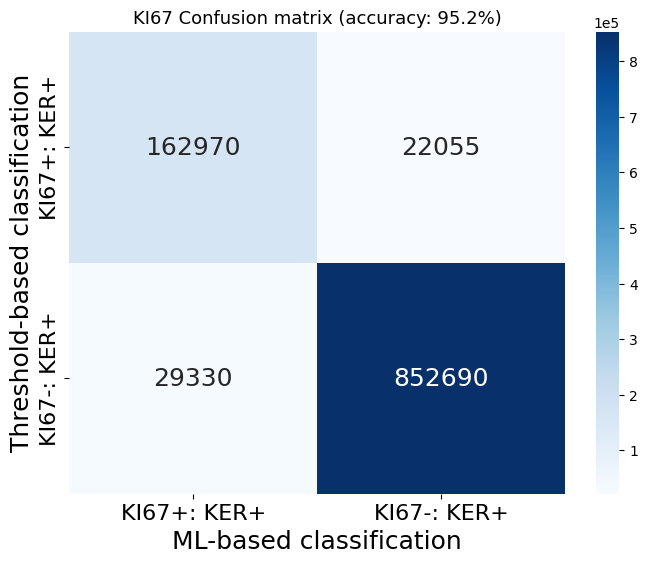

In [9]:
all_thr_subset = thr_label[thr_label['Classification'].isin(['KI67+: KER+', 'KI67-: KER+'])]
all_ML_subset = ML_all[ML_all['Classification'].isin(['KI67+: KER+', 'KI67-: KER+'])]

# Merge the datasets on the 'Object ID' column
merged_data = pd.merge(all_ML_subset, all_thr_subset, on='Object ID', suffixes=('_ML', '_Thr'))

# Get common 'Object ID' cells between the two datasets
common_object_ids = set(all_ML_subset['Object ID']).intersection(set(all_thr_subset['Object ID']))

# Filter the merged data to include only common 'Object ID' cells
merged_data_common = merged_data[merged_data['Object ID'].isin(common_object_ids)]

# Initialize counts for each class combination
class_counts = {
    'KI67+: KER+': {'KI67+: KER+': 0, 'KI67-: KER+': 0},
    'KI67-: KER+': {'KI67+: KER+': 0, 'KI67-: KER+': 0},
}

# Iterate through the merged data and count occurrences of each class combination
for _, row in merged_data_common.iterrows():
    class_counts[row['Classification_ML']][row['Classification_Thr']] += 1

# Print the class counts
for true_class, predicted_classes in class_counts.items():
    print(f'True Class: {true_class}')
    for predicted_class, count in predicted_classes.items():
        print(f'Predicted Class: {predicted_class}, Count: {count}')
    print()

# Define class labels
classes = ['KI67+: KER+', 'KI67-: KER+']
#classes = ['KER+: pNDRG1+', 'KER+: pNDRG1-', 'KER-: pNDRG1+', 'KER-: pNDRG1-']

# Create a DataFrame from class counts dictionary
confusion_df = pd.DataFrame(class_counts, index=classes)

# Sum up counts along the diagonal (correct predictions)
correct_predictions = np.diag(confusion_df)

# Total number of samples
total_samples = confusion_df.values.sum()

# Calculate ratio of agreement
agreement_ratio = (correct_predictions.sum() / total_samples) * 100

print("Ratio of agreement between the two methods:", agreement_ratio)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 18})
plt.title(f'KI67 Confusion matrix (accuracy: {agreement_ratio:.1f}%)', fontsize=13)
plt.ylabel('Threshold-based classification', fontsize=18)
plt.xlabel('ML-based classification', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
# Set scientific notation for the colorbar
cbar = ax.collections[0].colorbar
cbar.ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.savefig("/Users/antoine/Harvard/IAC/NinaKozlova/Submission/Supplementary/figures/KI67_confusion_matrix_intensity_features.png")
plt.show()

In [39]:
# Calculate precision and recall
precision = {}
recall = {}

for cls in classes:
    tp = class_counts[cls][cls]
    fp = sum(class_counts[cls2][cls] for cls2 in classes if cls2 != cls)
    fn = sum(class_counts[cls][cls2] for cls2 in classes if cls2 != cls)
    
    precision[cls] = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall[cls] = tp / (tp + fn) if (tp + fn) > 0 else 0

# Print precision and recall
for cls in classes:
    print(f"Class: {cls}")
    print(f"  Precision: {precision[cls]:.2f}")
    print(f"  Recall: {recall[cls]:.2f}")

Class: KI67+: KER+
  Precision: 0.86
  Recall: 0.90
Class: KI67-: KER+
  Precision: 0.98
  Recall: 0.97


### Threshold vs ML single measurement

In [40]:
folder_thr = "/Users/antoine/Harvard/IAC/NinaKozlova/20240425_SW1990_Ki67/Results/ML_classifier/20240613_threshold_ki67_nucleus_max"
thr_label = load_data(folder_thr)

folder_ML = "/Users/antoine/Harvard/IAC/NinaKozlova/20240425_SW1990_Ki67/Results/ML_classifier/20240613_single_measurement_features"
ML_all = load_data(folder_ML)

# Count how many 'Object ID' cells are common between the two datasets
common_object_ids = len(set(ML_all['Object ID']).intersection(set(thr_label['Object ID'])))
print("Number of common Object IDs between the two datasets:", common_object_ids)

flag = (len(set(ML_all['Object ID'])) == len(set(thr_label['Object ID'])))
print("Datasets have the same number of cells:", flag)

# Create a lookup table for class name conversion
class_lookup_ML = {
    'KER+: KI67+': 'KI67+: KER+',
    'KER+: KI67-': 'KI67-: KER+',
    'KER-: KI67-': 'KI67-: KER-',
    'KER-: KI67+': 'KI67+: KER-',
    'KI67+: KER+': 'KI67+: KER+',
    'KI67+: KER-': 'KI67+: KER-',
    'KI67-: KER+': 'KI67-: KER+',
    'KI67-: KER-': 'KI67-: KER-'
}

# Apply the lookup table to the 'Classification' column in ML_all
ML_all['Classification'] = ML_all['Classification'].map(class_lookup_ML)


# Create a lookup table for class name conversion in thr_label
class_lookup = {
    'KER_488: KI67_647': 'KI67+: KER+',
    'KER_488': 'KI67-: KER+',
    'KI67_647': 'KI67+: KER-',
}

# Apply the lookup table to the 'Classification' column in thr_label
thr_label['Classification'] = thr_label['Classification'].map(class_lookup)

# Handle any remaining NaN values explicitly
thr_label['Classification'] = thr_label['Classification'].fillna('KI67-: KER-')

# Verify that there are no NaN values in the 'Classification' column after mapping
nan_count = thr_label['Classification'].isna().sum()
print("Number of NaN values in 'Classification' column after mapping:", nan_count)

Cell count: 272961
Cell count: 95389
Cell count: 154157
Cell count: 306898
Cell count: 58254
Cell count: 80063
Cell count: 91509
Cell count: 99662
Cell count: 272961
Cell count: 95389
Cell count: 154157
Cell count: 306898
Cell count: 58254
Cell count: 80063
Cell count: 91509
Cell count: 99662
Number of common Object IDs between the two datasets: 1158893
Datasets have the same number of cells: True
Number of NaN values in 'Classification' column after mapping: 0


True Class: KI67+: KER+
Predicted Class: KI67+: KER+, Count: 151955
Predicted Class: KI67-: KER+, Count: 13400
Predicted Class: KI67+: KER-, Count: 111
Predicted Class: KI67-: KER-, Count: 7

True Class: KI67-: KER+
Predicted Class: KI67+: KER+, Count: 36586
Predicted Class: KI67-: KER+, Count: 903970
Predicted Class: KI67+: KER-, Count: 37
Predicted Class: KI67-: KER-, Count: 1787

True Class: KI67+: KER-
Predicted Class: KI67+: KER+, Count: 1666
Predicted Class: KI67-: KER+, Count: 27
Predicted Class: KI67+: KER-, Count: 1145
Predicted Class: KI67-: KER-, Count: 133

True Class: KI67-: KER-
Predicted Class: KI67+: KER+, Count: 924
Predicted Class: KI67-: KER+, Count: 28818
Predicted Class: KI67+: KER-, Count: 406
Predicted Class: KI67-: KER-, Count: 17921

Ratio of agreement between the two methods: 92.76015991122563


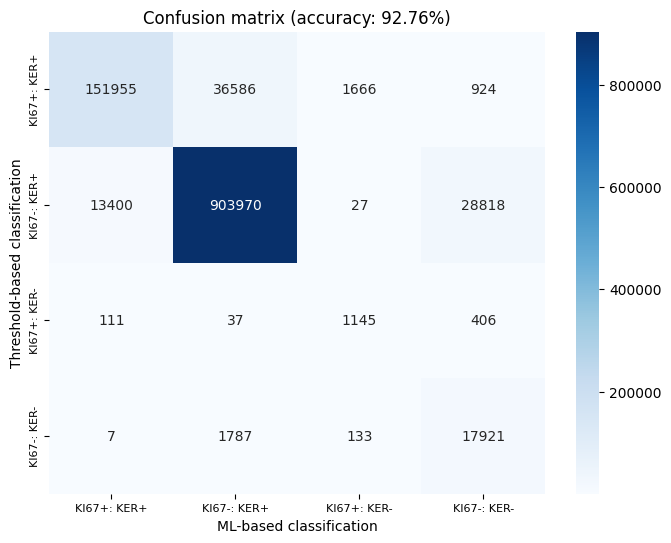

In [41]:
# Merge the datasets on the 'Object ID' column
merged_data = pd.merge(ML_all, thr_label, on='Object ID', suffixes=('_ML', '_Thr'))

# Get common 'Object ID' cells between the two datasets
common_object_ids = set(ML_all['Object ID']).intersection(set(thr_label['Object ID']))

# Filter the merged data to include only common 'Object ID' cells
merged_data_common = merged_data[merged_data['Object ID'].isin(common_object_ids)]

# Initialize counts for each class combination
class_counts = {
    'KI67+: KER+': {'KI67+: KER+': 0, 'KI67-: KER+': 0, 'KI67+: KER-': 0, 'KI67-: KER-': 0},
    'KI67-: KER+': {'KI67+: KER+': 0, 'KI67-: KER+': 0, 'KI67+: KER-': 0, 'KI67-: KER-': 0},
    'KI67+: KER-': {'KI67+: KER+': 0, 'KI67-: KER+': 0, 'KI67+: KER-': 0, 'KI67-: KER-': 0},
    'KI67-: KER-': {'KI67+: KER+': 0, 'KI67-: KER+': 0, 'KI67+: KER-': 0, 'KI67-: KER-': 0}
}

# Iterate through the merged data and count occurrences of each class combination
for _, row in merged_data_common.iterrows():
    class_counts[row['Classification_ML']][row['Classification_Thr']] += 1

# Print the class counts
for true_class, predicted_classes in class_counts.items():
    print(f'True Class: {true_class}')
    for predicted_class, count in predicted_classes.items():
        print(f'Predicted Class: {predicted_class}, Count: {count}')
    print()

# Define class labels
classes = ['KI67+: KER+', 'KI67-: KER+', 'KI67+: KER-', 'KI67-: KER-']
#classes = ['KER+: pNDRG1+', 'KER+: pNDRG1-', 'KER-: pNDRG1+', 'KER-: pNDRG1-']

# Create a DataFrame from class counts dictionary
confusion_df = pd.DataFrame(class_counts, index=classes)

# Sum up counts along the diagonal (correct predictions)
correct_predictions = np.diag(confusion_df)

# Total number of samples
total_samples = confusion_df.values.sum()

# Calculate ratio of agreement
agreement_ratio = (correct_predictions.sum() / total_samples) * 100

print("Ratio of agreement between the two methods:", agreement_ratio)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion matrix (accuracy: {agreement_ratio:.2f}%)')
plt.ylabel('Threshold-based classification')
plt.xlabel('ML-based classification')
plt.tick_params(axis='both', which='major', labelsize=8)  # Change 12 to your desired font size
plt.show()

True Class: KI67+: KER+
Predicted Class: KI67+: KER+, Count: 151955
Predicted Class: KI67-: KER+, Count: 13400

True Class: KI67-: KER+
Predicted Class: KI67+: KER+, Count: 36586
Predicted Class: KI67-: KER+, Count: 903970

Ratio of agreement between the two methods: 95.48010644617875


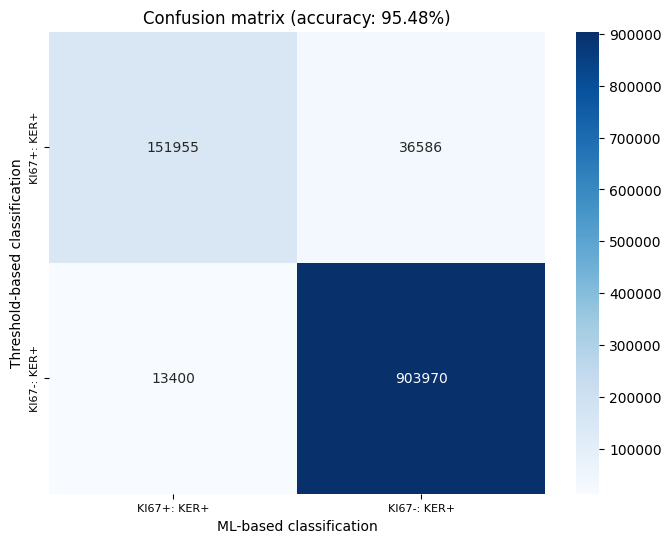

In [42]:
all_thr_subset = thr_label[thr_label['Classification'].isin(['KI67+: KER+', 'KI67-: KER+'])]
all_ML_subset = ML_all[ML_all['Classification'].isin(['KI67+: KER+', 'KI67-: KER+'])]

# Merge the datasets on the 'Object ID' column
merged_data = pd.merge(all_ML_subset, all_thr_subset, on='Object ID', suffixes=('_ML', '_Thr'))

# Get common 'Object ID' cells between the two datasets
common_object_ids = set(all_ML_subset['Object ID']).intersection(set(all_thr_subset['Object ID']))

# Filter the merged data to include only common 'Object ID' cells
merged_data_common = merged_data[merged_data['Object ID'].isin(common_object_ids)]

# Initialize counts for each class combination
class_counts = {
    'KI67+: KER+': {'KI67+: KER+': 0, 'KI67-: KER+': 0},
    'KI67-: KER+': {'KI67+: KER+': 0, 'KI67-: KER+': 0},
}

# Iterate through the merged data and count occurrences of each class combination
for _, row in merged_data_common.iterrows():
    class_counts[row['Classification_ML']][row['Classification_Thr']] += 1

# Print the class counts
for true_class, predicted_classes in class_counts.items():
    print(f'True Class: {true_class}')
    for predicted_class, count in predicted_classes.items():
        print(f'Predicted Class: {predicted_class}, Count: {count}')
    print()

# Define class labels
classes = ['KI67+: KER+', 'KI67-: KER+']
#classes = ['KER+: pNDRG1+', 'KER+: pNDRG1-', 'KER-: pNDRG1+', 'KER-: pNDRG1-']

# Create a DataFrame from class counts dictionary
confusion_df = pd.DataFrame(class_counts, index=classes)

# Sum up counts along the diagonal (correct predictions)
correct_predictions = np.diag(confusion_df)

# Total number of samples
total_samples = confusion_df.values.sum()

# Calculate ratio of agreement
agreement_ratio = (correct_predictions.sum() / total_samples) * 100

print("Ratio of agreement between the two methods:", agreement_ratio)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion matrix (accuracy: {agreement_ratio:.2f}%)')
plt.ylabel('Threshold-based classification')
plt.xlabel('ML-based classification')
plt.tick_params(axis='both', which='major', labelsize=8)  # Change 12 to your desired font size
plt.show()

## Rest

## Load data NDRG1

In [13]:
# Threshold-based classification

folder_path = "/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240502_medians"

# Get a list of all CSV files in the folder
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
file_paths = natsort.natsorted(file_paths)

# Specify the columns you want to load
columns_to_load = ['Class', 
                   'DAPI: Nucleus: Median', 
                   'KER_488: Cytoplasm: Median', 
                   'pNDRG1_647: Cell: Median', 
                   'pNDRG1_647: Cell: Max', 
                   'FN_568: Cell: Median', 
                   'Nucleus: Area µm^2', 
                   'Signed distance to annotation Stroma µm']

# Read and filter each CSV file
dfs_ker488_pndrg1_647 = []
dfs_ker488 = []
all = []

for file_path in file_paths:
    print(file_path)
    df = pd.read_csv(file_path, usecols=columns_to_load)
    df_ker488_pndrg1_647 = df[df['Class'] == 'KER_488: pNDRG1_647']  # Filter rows by 'Class' for KER_488: pNDRG1_647
    df_ker488 = df[df['Class'] == 'KER_488']  # Filter rows by 'Class' for KER_488
    dfs_ker488_pndrg1_647.append(df_ker488_pndrg1_647)
    dfs_ker488.append(df_ker488)
    all.append(df)

# Concatenate all filtered datasets
ker_pndrg_data_thr = pd.concat(dfs_ker488_pndrg1_647, ignore_index=True)
ker_data_thr = pd.concat(dfs_ker488, ignore_index=True)
all_thr = pd.concat(all, ignore_index=True)

/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240502_medians/SW shC Dox GEM  #1.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240502_medians/SW shC Dox GEM  #2.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240502_medians/SW shC Dox GEM  #3.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240502_medians/SW shC Dox GEM  #4.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240502_medians/SW shC Dox GEM  #5.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_pNDRG1/Results/spatial_data/20240502_medians/SW shC Dox GEM  #11.vsi - 20x_DAPI, FITC, TRITC, CY5_01.csv
/Users/antoine/Harvard/IAC/NinaKozlova/202401

## Load Ki67 data

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import natsort

folder_path = "/Users/antoine/Harvard/IAC/NinaKozlova/20240425_SW1990_Ki67/Results/spatial_data"

# Specify the columns you want to load
columns_to_load = ['Class', 
                   'DAPI: Nucleus: Median', 
                   'KER_488: Cytoplasm: Median', 
                   'KI67_647: Nucleus: Median', 
                   'KI67_647: Nucleus: Max', 
                   'FN_568: Cell: Median', 
                   'Nucleus: Area µm^2', 
                   'Signed distance to annotation Stroma µm']


control_replicates = ["Image_SW1990 shC GEM #3 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #3 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #1 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #1 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #2 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #2 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #4 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #4 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #5 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #5 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #11 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #11 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #14 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #14 Ker488 FN568 Ki67 647 yH800.csv", 
                      "Image_SW1990 shC GEM #15 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #15 Ker488 FN568 Ki67 647 yH800.csv", 
                      ]
                   
# Read and filter each CSV file
dfs_ker488_ki67_control = []
dfs_ker488_control = []

# Sort file paths naturally
control_files = natsort.natsorted(control_replicates)

for file_path in control_files:
    print(file_path)
    df = pd.read_csv(os.path.join(folder_path, file_path), usecols=columns_to_load)
    df_ker488_ki67 = df[df['Class'] == 'KER_488: KI67_647']  # Filter rows by 'Class' for KER_488: Ki67_647
    df_ker488 = df[df['Class'] == 'KER_488']  # Filter rows by 'Class' for KER_488
    dfs_ker488_ki67_control.append(df_ker488_ki67)
    dfs_ker488_control.append(df_ker488)

# Concatenate all filtered datasets
control_ker488_ki67 = pd.concat(dfs_ker488_ki67_control, ignore_index=True)
control_ker488 = pd.concat(dfs_ker488_control, ignore_index=True)

Image_SW1990 shC GEM #1 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #1 Ker488 FN568 Ki67 647 yH800.csv
Image_SW1990 shC GEM #2 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #2 Ker488 FN568 Ki67 647 yH800.csv
Image_SW1990 shC GEM #3 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #3 Ker488 FN568 Ki67 647 yH800.csv
Image_SW1990 shC GEM #4 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #4 Ker488 FN568 Ki67 647 yH800.csv
Image_SW1990 shC GEM #5 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #5 Ker488 FN568 Ki67 647 yH800.csv
Image_SW1990 shC GEM #11 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #11 Ker488 FN568 Ki67 647 yH800.csv
Image_SW1990 shC GEM #14 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #14 Ker488 FN568 Ki67 647 yH800.csv
Image_SW1990 shC GEM #15 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #15 Ker488 FN568 Ki67 647 yH800.csv


## Load data yH2AX

In [4]:
folder_path = "/Users/antoine/Harvard/IAC/NinaKozlova/20240119_SW1990_yH2AX/Results/spatial_data/20240405"

control_replicates = ["SW shC Dox G #1 yH568 FN647 Ker488_01.vsi - 20x.csv", 
                      "SW shC Dox G #2 yH568 FN647 Ker488_01.vsi - 20x.csv", 
                      "SW shC Dox G #3 yH568 FN647 Ker488_01.vsi - 20x.csv", 
                      "SW shC Dox G #4 yH568 Ker488 FN647_01.vsi - 20x.csv", 
                      "SW shC Dox G #5 yH568 FN647 Ker488_01.vsi - 20x.csv", 
                      "SW shC Dox G #11 yH568 FN647 Ker488_01.vsi - 20x.csv", 
                      "SW shC Dox G #14 yH568 Ker488 FN647_01.vsi - 20x.csv", 
                      "SW shC DOX G #15 yH 568 Ker488 FN647_02.vsi - 20x.csv"]

ko_replicates = ["SW 598 DOX G #31 yH 568 Ker488 FN647_01.vsi - 20x.csv", 
                 "SW 598 DOX G #32 yH 568 Ker488 FN647_01.vsi - 20x.csv", 
                 "SW 598 DOX G #33 yH 568 Ker488 FN647_01.vsi - 20x.csv", 
                 "SW 598 DOX G #35 yH 568 Ker488 FN647_01.vsi - 20x.csv", 
                 "SW 598 DOX G #36 yH 568 Ker488 FN647_01.vsi - 20x.csv", 
                 "SW 598 DOX G #37 yH 568 Ker488 FN647_01.vsi - 20x.csv", 
                 "SW 598 DOX G #38 yH 568 Ker488 FN647_01.vsi - 20x.csv", 
                 "SW 598 DOX G #39 yH 568 Ker488 FN647_02.vsi - 20x.csv", 
                 "SW 598 DOX G #40 yH 568 Ker488 FN647_02.vsi - 20x.csv"]

# Specify the columns you want to load
columns_to_load = ['Class', 
                   'DAPI: Nucleus: Median', 
                   'KER_488: Cytoplasm: MedianTotalIntensity', 
                   'yH2AX_568: Nucleus: MedianTotalIntensity', 
                   'FN_647: Cell: Median', 
                   'Nucleus: Area µm^2', 
                   'Signed distance to annotation Stroma µm']
                   
# Read and filter each CSV file
dfs_ker488_pndrg1_647_control = []
dfs_ker488_control = []
dfs_ker488_pndrg1_647_ko = []
dfs_ker488_ko = []

# Sort file paths naturally
control_files = natsort.natsorted(control_replicates)

for file_path in control_files:
    print(file_path)
    df = pd.read_csv(os.path.join(folder_path, file_path), usecols=columns_to_load)
    df_ker488_pndrg1_647 = df[df['Class'] == 'KER_488: yH2AX_568']  # Filter rows by 'Class' for KER_488: pNDRG1_647
    df_ker488 = df[df['Class'] == 'KER_488']  # Filter rows by 'Class' for KER_488
    dfs_ker488_pndrg1_647_control.append(df_ker488_pndrg1_647)
    dfs_ker488_control.append(df_ker488)

# Concatenate all filtered datasets
control_ker_yh2ax_data = pd.concat(dfs_ker488_pndrg1_647_control, ignore_index=True)
control_ker_data = pd.concat(dfs_ker488_control, ignore_index=True)

# Sort file paths naturally
ko_files = natsort.natsorted(ko_replicates)

for file_path in ko_files:
    print(file_path)
    df = pd.read_csv(os.path.join(folder_path, file_path), usecols=columns_to_load)
    df_ker488_pndrg1_647 = df[df['Class'] == 'KER_488: yH2AX_568']  # Filter rows by 'Class' for KER_488: pNDRG1_647
    df_ker488 = df[df['Class'] == 'KER_488']  # Filter rows by 'Class' for KER_488
    dfs_ker488_pndrg1_647_ko.append(df_ker488_pndrg1_647)
    dfs_ker488_ko.append(df_ker488)

# Concatenate all filtered datasets
ko_ker_yh2ax_data = pd.concat(dfs_ker488_pndrg1_647_ko, ignore_index=True)
ko_ker_data = pd.concat(dfs_ker488_ko, ignore_index=True)

SW shC DOX G #15 yH 568 Ker488 FN647_02.vsi - 20x.csv
SW shC Dox G #1 yH568 FN647 Ker488_01.vsi - 20x.csv
SW shC Dox G #2 yH568 FN647 Ker488_01.vsi - 20x.csv
SW shC Dox G #3 yH568 FN647 Ker488_01.vsi - 20x.csv
SW shC Dox G #4 yH568 Ker488 FN647_01.vsi - 20x.csv
SW shC Dox G #5 yH568 FN647 Ker488_01.vsi - 20x.csv
SW shC Dox G #11 yH568 FN647 Ker488_01.vsi - 20x.csv
SW shC Dox G #14 yH568 Ker488 FN647_01.vsi - 20x.csv
SW 598 DOX G #31 yH 568 Ker488 FN647_01.vsi - 20x.csv
SW 598 DOX G #32 yH 568 Ker488 FN647_01.vsi - 20x.csv
SW 598 DOX G #33 yH 568 Ker488 FN647_01.vsi - 20x.csv
SW 598 DOX G #35 yH 568 Ker488 FN647_01.vsi - 20x.csv
SW 598 DOX G #36 yH 568 Ker488 FN647_01.vsi - 20x.csv
SW 598 DOX G #37 yH 568 Ker488 FN647_01.vsi - 20x.csv
SW 598 DOX G #38 yH 568 Ker488 FN647_01.vsi - 20x.csv
SW 598 DOX G #39 yH 568 Ker488 FN647_02.vsi - 20x.csv
SW 598 DOX G #40 yH 568 Ker488 FN647_02.vsi - 20x.csv


## Combined plot of pNDRG1 and yH2AX signal intensity over distance

## Difference in activity between the two cell types

/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_68033/2483936459.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_intensity_1 = ker_pndrg_data.groupby(distance_bins_1)['pNDRG1_647: Cell: MedianTotalIntensity'].mean()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_68033/2483936459.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_error_1 = ker_pndrg_data.groupby(distance_bins_1)['pNDRG1_647: Cell: MedianTotalIntensity'].sem()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_68033/2483936459.py:23: FutureWarning: The default of observed=False is deprecated and 

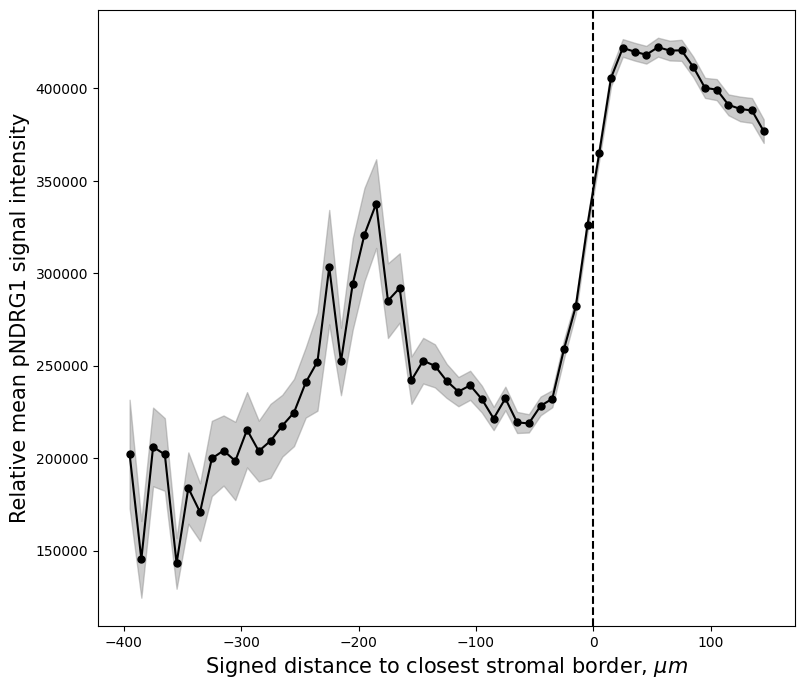

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Define bin size and create distance bins for the first set of data
bin_size = 10
min_dist = -150
max_dist = 160
distance_bins_1 = pd.cut(ker_pndrg_data['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)

# Calculate median intensity for each distance bin for the first set of data
median_intensity_1 = ker_pndrg_data.groupby(distance_bins_1)['pNDRG1_647: Cell: MedianTotalIntensity'].mean()

# Calculate standard error for each distance bin for the first set of data
std_error_1 = ker_pndrg_data.groupby(distance_bins_1)['pNDRG1_647: Cell: MedianTotalIntensity'].sem()

# Calculate bin midpoints for the first set of data
bin_midpoints_1 = [(bin.left + bin.right) / 2 for bin in distance_bins_1.cat.categories]

# Define bin size and create distance bins for the second set of data
distance_bins_2 = pd.cut(ker_data['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)

# Calculate median intensity for each distance bin for the second set of data
median_intensity_2 = ker_data.groupby(distance_bins_2)['pNDRG1_647: Cell: MedianTotalIntensity'].mean()

# Calculate standard error for each distance bin for the second set of data
std_error_2 = ker_data.groupby(distance_bins_2)['pNDRG1_647: Cell: MedianTotalIntensity'].sem()

# Calculate bin midpoints for the second set of data
bin_midpoints_2 = [(bin.left + bin.right) / 2 for bin in distance_bins_2.cat.categories]

# Calculate the difference between the two median intensities
diff_line = median_intensity_1.values - median_intensity_2.values

# Calculate the combined standard error
diff_std = np.sqrt(std_error_1**2 + std_error_2**2)

# Plotting the difference line
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))

ax1.set_ylabel(r'Relative mean pNDRG1 signal intensity', color='black', fontsize=15)
ax1.axvline(x=0, ls='--', color='black')

# Plot the gray surface representing uncertainty
ax1.fill_between(bin_midpoints_1, diff_line - diff_std, diff_line + diff_std, color='gray', alpha=0.4)

# Plot the difference line with error bars and specify different alpha values
ax1.errorbar(bin_midpoints_1, diff_line, color='black', linestyle='-', marker='o', markersize=5, alpha=1)

#ax1.set_ylim(0, 300000)

plt.xlabel(r'Signed distance to closest stromal border, $µm$', fontsize=15)
#plt.savefig("/Users/antoine/Harvard/IAC/NinaKozlova/20240412_presentation_materials/20240410_AsPC_pNDRG1_mean_interv0to150.png", dpi=300)
plt.show()


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_73520/954459024.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_intensity_1 = ker_pndrg_data.groupby(distance_bins_1)['pNDRG1_647: Cell: MedianTotalIntensity'].mean()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_73520/954459024.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_error_1 = ker_pndrg_data.groupby(distance_bins_1)['pNDRG1_647: Cell: MedianTotalIntensity'].sem()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_73520/954459024.py:26: FutureWarning: The default of observed=False is deprecated and wil

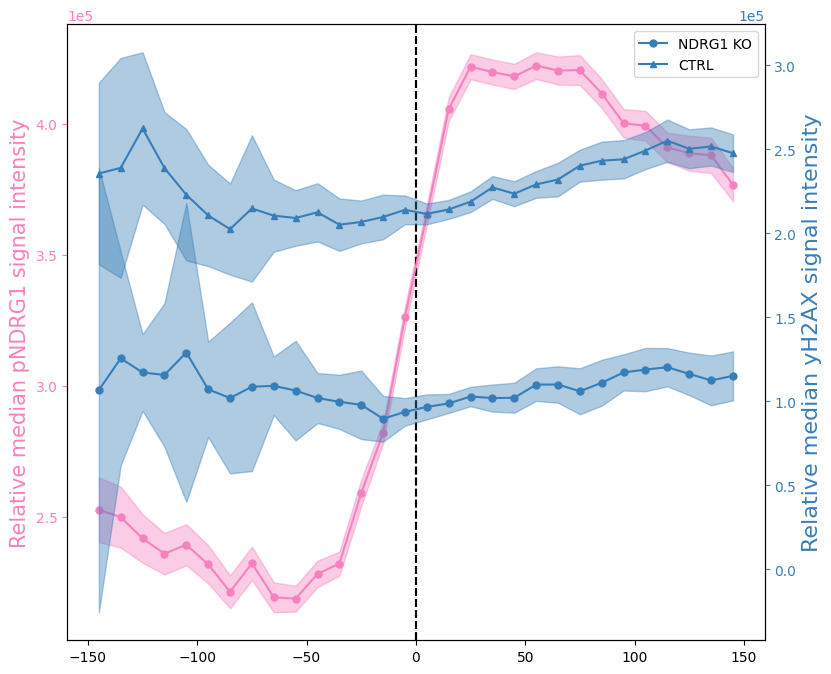

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Define bin size and create distance bins for the first set of data
bin_size = 10
min_dist = -150
max_dist = 160

distance_bins_1 = pd.cut(ker_pndrg_data['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)

# Calculate median intensity for each distance bin for the first set of data
median_intensity_1 = ker_pndrg_data.groupby(distance_bins_1)['pNDRG1_647: Cell: MedianTotalIntensity'].mean()

# Calculate standard error for each distance bin for the first set of data
std_error_1 = ker_pndrg_data.groupby(distance_bins_1)['pNDRG1_647: Cell: MedianTotalIntensity'].sem()

# Calculate bin midpoints for the first set of data
bin_midpoints_1 = [(bin.left + bin.right) / 2 for bin in distance_bins_1.cat.categories]

# Define bin size and create distance bins for the second set of data
distance_bins_2 = pd.cut(ker_data['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)

# Calculate median intensity for each distance bin for the second set of data
median_intensity_2 = ker_data.groupby(distance_bins_2)['pNDRG1_647: Cell: MedianTotalIntensity'].mean()

# Calculate standard error for each distance bin for the second set of data
std_error_2 = ker_data.groupby(distance_bins_2)['pNDRG1_647: Cell: MedianTotalIntensity'].sem()

# Calculate bin midpoints for the second set of data
bin_midpoints_2 = [(bin.left + bin.right) / 2 for bin in distance_bins_2.cat.categories]

# Calculate the difference between the two median intensities
diff_line = median_intensity_1.values - median_intensity_2.values

# Calculate the combined standard error
diff_std = np.sqrt(std_error_1**2 + std_error_2**2)

# Plotting the difference line
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))

ax1.set_ylabel(r'Relative median pNDRG1 signal intensity', color='#f781bf', fontsize=15)
ax1.tick_params(axis='y', colors='#f781bf')
ax1.axvline(x=0, ls='--', color='black')
# Plot the gray surface representing uncertainty
ax1.fill_between(bin_midpoints_1, diff_line - diff_std, diff_line + diff_std, color='#f781bf', alpha=0.4)

# Plot the difference line with error bars and specify different alpha values
ax1.errorbar(bin_midpoints_1, diff_line, color='#f781bf', linestyle='-', marker='o', markersize=5, alpha=1)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

distance_bins_1_ko = pd.cut(ko_ker_yh2ax_data['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
distance_bins_1_ctl = pd.cut(control_ker_yh2ax_data['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)

# Calculate median intensity for each distance bin for the first set of data
median_intensity_1_ko = ko_ker_yh2ax_data.groupby(distance_bins_1_ko)['yH2AX_568: Nucleus: MedianTotalIntensity'].median()
median_intensity_1_ctl = control_ker_yh2ax_data.groupby(distance_bins_1_ctl)['yH2AX_568: Nucleus: MedianTotalIntensity'].median()

# Calculate standard error for each distance bin for the first set of data
std_error_1_ko = ko_ker_yh2ax_data.groupby(distance_bins_1_ko)['yH2AX_568: Nucleus: MedianTotalIntensity'].sem()
std_error_1_ctl = control_ker_yh2ax_data.groupby(distance_bins_1_ctl)['yH2AX_568: Nucleus: MedianTotalIntensity'].sem()

# Calculate bin midpoints for the first set of data
bin_midpoints_1_ko = [(bin.left + bin.right) / 2 for bin in distance_bins_1_ko.cat.categories]
bin_midpoints_1_ctl = [(bin.left + bin.right) / 2 for bin in distance_bins_1_ctl.cat.categories]

distance_bins_1_ko = pd.cut(ko_ker_yh2ax_data['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
distance_bins_1_ctl = pd.cut(control_ker_yh2ax_data['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)

# Define bin size and create distance bins for the second set of data
distance_bins_2_ko = pd.cut(ko_ker_data['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
distance_bins_2_ctl = pd.cut(control_ker_data['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)

# Calculate median intensity for each distance bin for the second set of data
median_intensity_2_ko = ko_ker_data.groupby(distance_bins_2_ko)['yH2AX_568: Nucleus: MedianTotalIntensity'].median()
median_intensity_2_ctl = control_ker_data.groupby(distance_bins_2_ctl)['yH2AX_568: Nucleus: MedianTotalIntensity'].median()

# Calculate standard error for each distance bin for the second set of data
std_error_2_ko = ko_ker_data.groupby(distance_bins_2_ko)['yH2AX_568: Nucleus: MedianTotalIntensity'].sem()
std_error_2_ctl = control_ker_data.groupby(distance_bins_2_ctl)['yH2AX_568: Nucleus: MedianTotalIntensity'].sem()

# Calculate bin midpoints for the second set of data
bin_midpoints_2_ko = [(bin.left + bin.right) / 2 for bin in distance_bins_2_ko.cat.categories]
bin_midpoints_2_ctl = [(bin.left + bin.right) / 2 for bin in distance_bins_2_ctl.cat.categories]

# Calculate the difference between the two median intensities
diff_line_ko = median_intensity_1_ko.values - median_intensity_2_ko.values
diff_line_ctl = median_intensity_1_ctl.values - median_intensity_2_ctl.values

# Calculate the combined standard error
diff_std_ko = np.sqrt(std_error_1_ko**2 + std_error_2_ko**2)
diff_std_ctl = np.sqrt(std_error_1_ctl**2 + std_error_2_ctl**2)

ax2 = ax1.twinx()
ax2.set_ylabel(r'Relative median yH2AX signal intensity', color='#377eb8', fontsize=16)
ax2.tick_params(axis='y', colors='#377eb8')
ax1.axvline(x=0, ls='--', color='black')
#ax1.set_ylim([0, 1000000])

# Plot the gray surface representing uncertainty
ax2.fill_between(bin_midpoints_1_ko, diff_line_ko - diff_std_ko, diff_line_ko + diff_std_ko, color='#377eb8', alpha=0.4)
ax2.fill_between(bin_midpoints_1_ctl, diff_line_ctl - diff_std_ctl, diff_line_ctl + diff_std_ctl, color='#377eb8', alpha=0.4)

# Plot the difference line with error bars
ax2.errorbar(bin_midpoints_1_ko, diff_line_ko, color='#377eb8', linestyle='-', marker='o', markersize=5, alpha=1, label='NDRG1 KO')
ax2.errorbar(bin_midpoints_1_ctl, diff_line_ctl, color='#377eb8', linestyle='-', marker='^', markersize=5, alpha=1, label='CTRL')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.xlabel(r'Signed distance to closest stromal border, $µm$', color='black', fontsize=16)
plt.legend()
plt.savefig("/Users/antoine/Harvard/IAC/NinaKozlova/20240412_presentation_materials/pNDRG1_yH2AX_combined/SW1990_combined_median_dist-150to150.png", dpi=300)
plt.show()


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_7295/937678045.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_intensity_1_ko = ko_ker_yh2ax_data.groupby(distance_bins_1_ko)['yH2AX_568: Nucleus: MedianTotalIntensity'].median()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_7295/937678045.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_intensity_1_ctl = control_ker_yh2ax_data.groupby(distance_bins_1_ctl)['yH2AX_568: Nucleus: MedianTotalIntensity'].median()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_7295/937678045.py:19: FutureWarning: The default o

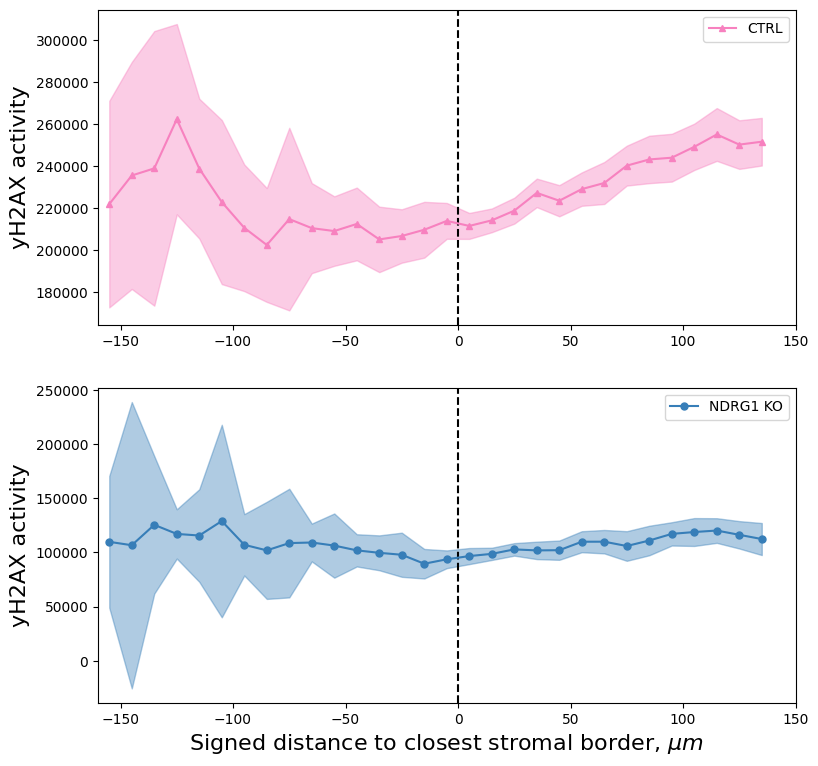

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Define bin size and create distance bins for the first set of data
bin_size = 10
min_dist = -160
max_dist = 150

distance_bins_1_ko = pd.cut(ko_ker_yh2ax_data['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
distance_bins_1_ctl = pd.cut(control_ker_yh2ax_data['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)

# Calculate median intensity for each distance bin for the first set of data
median_intensity_1_ko = ko_ker_yh2ax_data.groupby(distance_bins_1_ko)['yH2AX_568: Nucleus: MedianTotalIntensity'].median()
median_intensity_1_ctl = control_ker_yh2ax_data.groupby(distance_bins_1_ctl)['yH2AX_568: Nucleus: MedianTotalIntensity'].median()

# Calculate standard error for each distance bin for the first set of data
std_error_1_ko = ko_ker_yh2ax_data.groupby(distance_bins_1_ko)['yH2AX_568: Nucleus: MedianTotalIntensity'].sem()
std_error_1_ctl = control_ker_yh2ax_data.groupby(distance_bins_1_ctl)['yH2AX_568: Nucleus: MedianTotalIntensity'].sem()

# Calculate bin midpoints for the first set of data
bin_midpoints_1_ko = [(bin.left + bin.right) / 2 for bin in distance_bins_1_ko.cat.categories]
bin_midpoints_1_ctl = [(bin.left + bin.right) / 2 for bin in distance_bins_1_ctl.cat.categories]

# Define bin size and create distance bins for the second set of data
distance_bins_2_ko = pd.cut(ko_ker_data['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
distance_bins_2_ctl = pd.cut(control_ker_data['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)

# Calculate median intensity for each distance bin for the second set of data
median_intensity_2_ko = ko_ker_data.groupby(distance_bins_2_ko)['yH2AX_568: Nucleus: MedianTotalIntensity'].median()
median_intensity_2_ctl = control_ker_data.groupby(distance_bins_2_ctl)['yH2AX_568: Nucleus: MedianTotalIntensity'].median()

# Calculate standard error for each distance bin for the second set of data
std_error_2_ko = ko_ker_data.groupby(distance_bins_2_ko)['yH2AX_568: Nucleus: MedianTotalIntensity'].sem()
std_error_2_ctl = control_ker_data.groupby(distance_bins_2_ctl)['yH2AX_568: Nucleus: MedianTotalIntensity'].sem()

# Calculate bin midpoints for the second set of data
bin_midpoints_2_ko = [(bin.left + bin.right) / 2 for bin in distance_bins_2_ko.cat.categories]
bin_midpoints_2_ctl = [(bin.left + bin.right) / 2 for bin in distance_bins_2_ctl.cat.categories]

# Calculate the difference between the two median intensities
diff_line_ko = median_intensity_1_ko.values - median_intensity_2_ko.values
diff_line_ctl = median_intensity_1_ctl.values - median_intensity_2_ctl.values

# Calculate the combined standard error
diff_std_ko = np.sqrt(std_error_1_ko**2 + std_error_2_ko**2)
diff_std_ctl = np.sqrt(std_error_1_ctl**2 + std_error_2_ctl**2)

# Plotting the difference line
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 9))

ax1.set_ylabel(r'yH2AX activity', color='black', fontsize=16)
ax2.set_ylabel(r'yH2AX activity', color='black', fontsize=16)
ax1.axvline(x=0, ls='--', color='black')
ax2.axvline(x=0, ls='--', color='black')
# ax1.set_ylim([0, 1000000])
# ax2.set_ylim([0, 1000000])
ax1.set_xlim([min_dist, max_dist])
ax2.set_xlim([min_dist, max_dist])

# Plot the gray surface representing uncertainty
ax2.fill_between(bin_midpoints_1_ko, diff_line_ko - diff_std_ko, diff_line_ko + diff_std_ko, color='#377eb8', alpha=0.4)
#ax1.fill_between(bin_midpoints_2_ko, median_intensity_2_ko.values - std_error_2_ko, median_intensity_2_ko.values + std_error_2_ko, color='#377eb8', alpha=0.8)
ax1.fill_between(bin_midpoints_1_ctl, diff_line_ctl - diff_std_ctl, diff_line_ctl + diff_std_ctl, color='#f781bf', alpha=0.4)

# Plot the difference line with error bars
ax2.errorbar(bin_midpoints_1_ko, diff_line_ko, color='#377eb8', linestyle='-', marker='o', markersize=5, alpha=1, label='NDRG1 KO')
ax1.errorbar(bin_midpoints_1_ctl, diff_line_ctl, color='#f781bf', linestyle='-', marker='^', markersize=5, alpha=1, label='CTRL')

ax1.legend()
plt.xlabel(r'Signed distance to closest stromal border, $µm$', color='black', fontsize=16)
plt.legend()
#plt.savefig("/Users/antoine/Harvard/IAC/NinaKozlova/20240111_AsPC_yH2AX/Results/plots/spatial_analysis/zoomed_difference_spatial_median_ko_ctl_separated.png", dpi=300)
plt.show()


## Ki67 and pNDRG1

Image_SW1990 shC GEM #1 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #1 Ker488 FN568 Ki67 647 yH800.csv
Image_SW1990 shC GEM #2 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #2 Ker488 FN568 Ki67 647 yH800.csv
Image_SW1990 shC GEM #3 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #3 Ker488 FN568 Ki67 647 yH800.csv
Image_SW1990 shC GEM #4 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #4 Ker488 FN568 Ki67 647 yH800.csv
Image_SW1990 shC GEM #5 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #5 Ker488 FN568 Ki67 647 yH800.csv
Image_SW1990 shC GEM #11 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #11 Ker488 FN568 Ki67 647 yH800.csv
Image_SW1990 shC GEM #14 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #14 Ker488 FN568 Ki67 647 yH800.csv
Image_SW1990 shC GEM #15 Ker488 FN568 Ki67 647 yH800.vsi - SW1990 shC GEM #15 Ker488 FN568 Ki67 647 yH800.csv


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_68033/51769714.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_intensity_1 = control_ker488_ki67.groupby(distance_bins_1)['KI67_647: Nucleus: Median'].median()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_68033/51769714.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_error_1 = control_ker488_ki67.groupby(distance_bins_1)['KI67_647: Nucleus: Median'].sem()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_68033/51769714.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to T

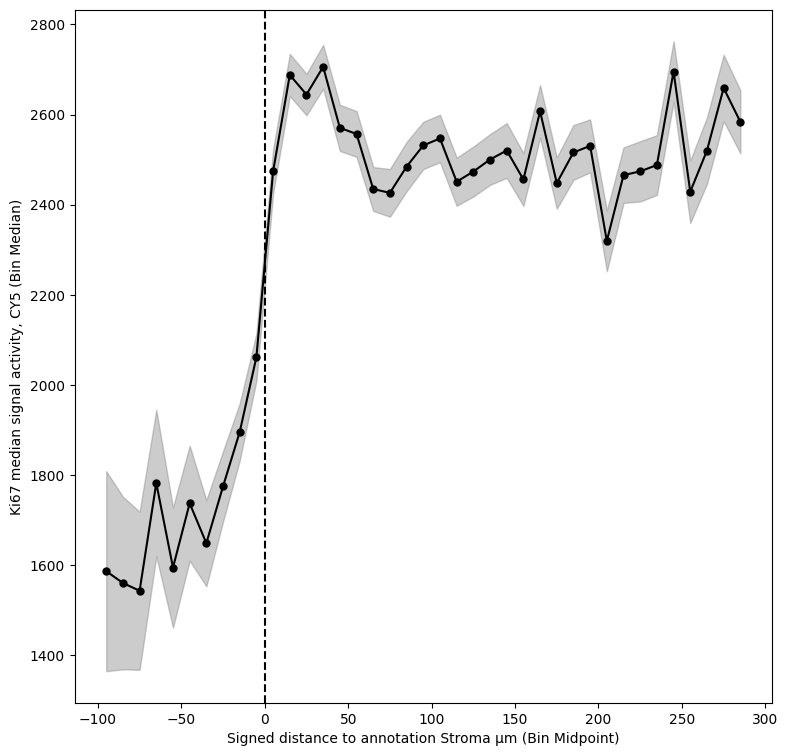

In [1]:


# Define bin size and create distance bins for the first set of data
bin_size = 10
min_dist = -100 # int(np.min(control_ker488_ki67['Signed distance to annotation Stroma µm']))
max_dist = 300 # int(np.max(control_ker488_ki67['Signed distance to annotation Stroma µm']))
distance_bins_1 = pd.cut(control_ker488_ki67['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)

# Calculate median intensity for each distance bin for the first set of data
median_intensity_1 = control_ker488_ki67.groupby(distance_bins_1)['KI67_647: Nucleus: Median'].median()

# Calculate standard error for each distance bin for the first set of data
std_error_1 = control_ker488_ki67.groupby(distance_bins_1)['KI67_647: Nucleus: Median'].sem()

# Calculate bin midpoints for the first set of data
bin_midpoints_1 = [(bin.left + bin.right) / 2 for bin in distance_bins_1.cat.categories]

# Define bin size and create distance bins for the second set of data
distance_bins_2 = pd.cut(control_ker488['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)

# Calculate median intensity for each distance bin for the second set of data
median_intensity_2 = control_ker488.groupby(distance_bins_2)['KI67_647: Nucleus: Median'].median()

# Calculate standard error for each distance bin for the second set of data
std_error_2 = control_ker488.groupby(distance_bins_2)['KI67_647: Nucleus: Median'].sem()

# Calculate bin midpoints for the second set of data
bin_midpoints_2 = [(bin.left + bin.right) / 2 for bin in distance_bins_2.cat.categories]

# Calculate the difference between the two median intensities
diff_line = median_intensity_1.values - median_intensity_2.values

# Calculate the combined standard error
diff_std = np.sqrt(std_error_1**2 + std_error_2**2)

# Plotting the difference line
fig, ax1 = plt.subplots(1, 1, figsize=(9, 9))

ax1.set_ylabel(r'Ki67 median signal activity, CY5 (Bin Median)', color='black')
ax1.axvline(x=0, ls='--', color='black')
#ax1.set_ylim([0, 1000000])

# Plot the gray surface representing uncertainty
ax1.fill_between(bin_midpoints_1, diff_line - diff_std, diff_line + diff_std, color='grey', alpha=0.4)

# Plot the difference line with error bars
ax1.errorbar(bin_midpoints_1, diff_line, color='black', linestyle='-', marker='o', markersize=5, alpha=1)

plt.xlabel('Signed distance to annotation Stroma µm (Bin Midpoint)')
#plt.savefig("/Users/antoine/Harvard/IAC/NinaKozlova/20240111_AsPC_yH2AX/Results/plots/spatial_analysis/full_difference_spatial_mean_control.png", dpi=300)
plt.show()

## Combined plot of pNDRG1 and Ki67 signal intensity over distance

/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_7295/197781867.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_intensity_1 = control_ker488_ki67.groupby(distance_bins_1)['KI67_647: Nucleus: Median'].median()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_7295/197781867.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_error_1 = control_ker488_ki67.groupby(distance_bins_1)['KI67_647: Nucleus: Median'].sem()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_7295/197781867.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to T

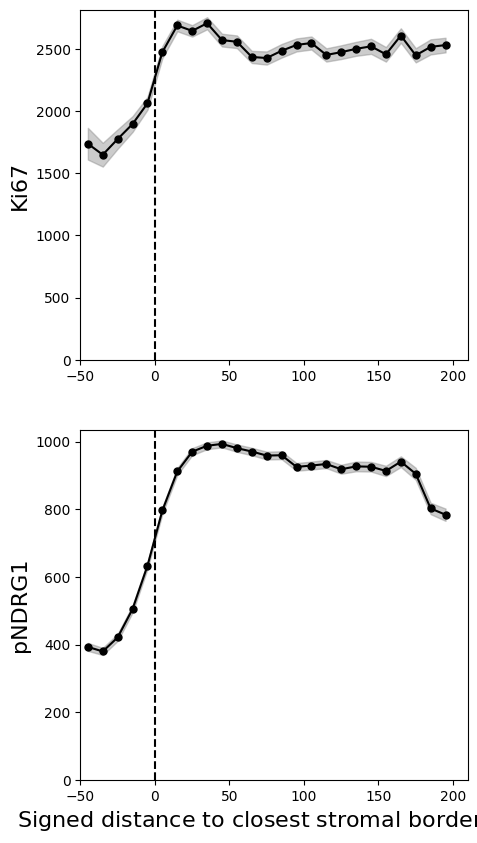

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Plotting the difference line
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 10))

# Define bin size and create distance bins for the first set of data
bin_size = 10
min_dist = -50
max_dist = 210

ax1.set_xlim([min_dist, max_dist])
ax2.set_xlim([min_dist, max_dist])
#ax3.set_xlim([min_dist, max_dist])

distance_bins_1 = pd.cut(control_ker488_ki67['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)

# Calculate median intensity for each distance bin for the first set of data
median_intensity_1 = control_ker488_ki67.groupby(distance_bins_1)['KI67_647: Nucleus: Median'].median()

# Calculate standard error for each distance bin for the first set of data
std_error_1 = control_ker488_ki67.groupby(distance_bins_1)['KI67_647: Nucleus: Median'].sem()

# Calculate bin midpoints for the first set of data
bin_midpoints_1 = [(bin.left + bin.right) / 2 for bin in distance_bins_1.cat.categories]

# Define bin size and create distance bins for the second set of data
distance_bins_2 = pd.cut(control_ker488['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)

# Calculate median intensity for each distance bin for the second set of data
median_intensity_2 = control_ker488.groupby(distance_bins_2)['KI67_647: Nucleus: Median'].median()

# Calculate standard error for each distance bin for the second set of data
std_error_2 = control_ker488.groupby(distance_bins_2)['KI67_647: Nucleus: Median'].sem()

# Calculate bin midpoints for the second set of data
bin_midpoints_2 = [(bin.left + bin.right) / 2 for bin in distance_bins_2.cat.categories]

# Calculate the difference between the two median intensities
diff_line = median_intensity_1.values - median_intensity_2.values

# Calculate the combined standard error
diff_std = np.sqrt(std_error_1**2 + std_error_2**2)

ax1.set_ylabel(r'Ki67', color='black', fontsize=16)
ax1.axvline(x=0, ls='--', color='black')
# Plot the gray surface representing uncertainty
ax1.fill_between(bin_midpoints_1, diff_line - diff_std, diff_line + diff_std, color='grey', alpha=0.4)
# Plot the difference line with error bars
ax1.errorbar(bin_midpoints_1, diff_line, color='black', linestyle='-', marker='o', markersize=5, alpha=1, label='CTRL')


distance_bins_1 = pd.cut(ker_pndrg_data['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)

# Calculate median intensity for each distance bin for the first set of data
median_intensity_1 = ker_pndrg_data.groupby(distance_bins_1)['pNDRG1_647: Cell: Median'].median()

# Calculate standard error for each distance bin for the first set of data
std_error_1 = ker_pndrg_data.groupby(distance_bins_1)['pNDRG1_647: Cell: Median'].sem()

# Calculate bin midpoints for the first set of data
bin_midpoints_1 = [(bin.left + bin.right) / 2 for bin in distance_bins_1.cat.categories]

# Define bin size and create distance bins for the second set of data
distance_bins_2 = pd.cut(ker_data['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)

# Calculate median intensity for each distance bin for the second set of data
median_intensity_2 = ker_data.groupby(distance_bins_2)['pNDRG1_647: Cell: Median'].median()

# Calculate standard error for each distance bin for the second set of data
std_error_2 = ker_data.groupby(distance_bins_2)['pNDRG1_647: Cell: Median'].sem()

# Calculate bin midpoints for the second set of data
bin_midpoints_2 = [(bin.left + bin.right) / 2 for bin in distance_bins_2.cat.categories]

# Calculate the difference between the two median intensities
diff_line = median_intensity_1.values - median_intensity_2.values

# Calculate the combined standard error
diff_std = np.sqrt(std_error_1**2 + std_error_2**2)

ax2.set_ylabel(r'pNDRG1', color='black', fontsize=16)
ax2.axvline(x=0, ls='--', color='black')
# Plot the gray surface representing uncertainty
ax2.fill_between(bin_midpoints_1, diff_line - diff_std, diff_line + diff_std, color='gray', alpha=0.4)
# Plot the difference line with error bars and specify different alpha values
ax2.errorbar(bin_midpoints_1, diff_line, color='black', linestyle='-', marker='o', markersize=5, alpha=1, label='CTRL')


'''distance_bins_1_ctl = pd.cut(control_ker_yh2ax_data['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)

# Calculate median intensity for each distance bin for the first set of data
median_intensity_1_ctl = control_ker_yh2ax_data.groupby(distance_bins_1_ctl)['yH2AX_568: Nucleus: MedianTotalIntensity'].median()

# Calculate standard error for each distance bin for the first set of data
std_error_1_ctl = control_ker_yh2ax_data.groupby(distance_bins_1_ctl)['yH2AX_568: Nucleus: MedianTotalIntensity'].sem()

# Calculate bin midpoints for the first set of data
bin_midpoints_1_ctl = [(bin.left + bin.right) / 2 for bin in distance_bins_1_ctl.cat.categories]

# Define bin size and create distance bins for the second set of data
distance_bins_2_ctl = pd.cut(control_ker_data['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)

# Calculate median intensity for each distance bin for the second set of data
median_intensity_2_ctl = control_ker_data.groupby(distance_bins_2_ctl)['yH2AX_568: Nucleus: MedianTotalIntensity'].median()

# Calculate standard error for each distance bin for the second set of data
std_error_2_ctl = control_ker_data.groupby(distance_bins_2_ctl)['yH2AX_568: Nucleus: MedianTotalIntensity'].sem()

# Calculate bin midpoints for the second set of data
bin_midpoints_2_ctl = [(bin.left + bin.right) / 2 for bin in distance_bins_2_ctl.cat.categories]

# Calculate the difference between the two median intensities
diff_line_ctl = median_intensity_1_ctl.values - median_intensity_2_ctl.values

# Calculate the combined standard error
diff_std_ctl = np.sqrt(std_error_1_ctl**2 + std_error_2_ctl**2)

ax3.set_ylabel(r'yH2AX', color='black', fontsize=16)
ax3.axvline(x=0, ls='--', color='black')
# Plot the gray surface representing uncertainty
ax3.fill_between(bin_midpoints_1_ctl, diff_line_ctl - diff_std_ctl, diff_line_ctl + diff_std_ctl, color='gray', alpha=0.4)
# Plot the difference line with error bars
ax3.errorbar(bin_midpoints_1_ctl, diff_line_ctl, linestyle='-', marker='^', markersize=5, alpha=1, color='black', label='CTRL')'''

ax1.set_ylim([0, None])
ax2.set_ylim([0, None])
#ax3.set_ylim([0, None])

plt.xlabel(r'Signed distance to closest stromal border, $µm$', color='black', fontsize=16)
plt.savefig("/Users/antoine/Harvard/IAC/NinaKozlova/20240425_SW1990_Ki67/Results/plots/full_SW1990_shC_Ki67_pDNRG1_yH2AX", dpi=300)
plt.show()


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_46136/2857899633.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_intensity_1 = control_ker488_ki67.groupby(distance_bins_1)['KI67_647: Nucleus: Median'].median()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_46136/2857899633.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_error_1 = control_ker488_ki67.groupby(distance_bins_1)['KI67_647: Nucleus: Median'].sem()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_46136/2857899633.py:17: FutureWarning: The default of observed=False is deprecated and will be change

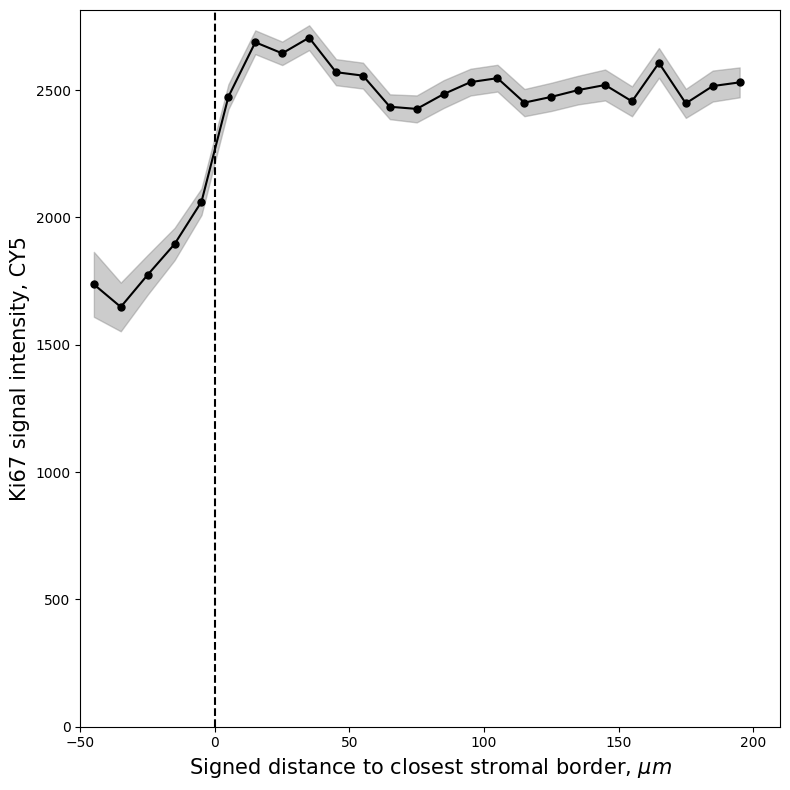

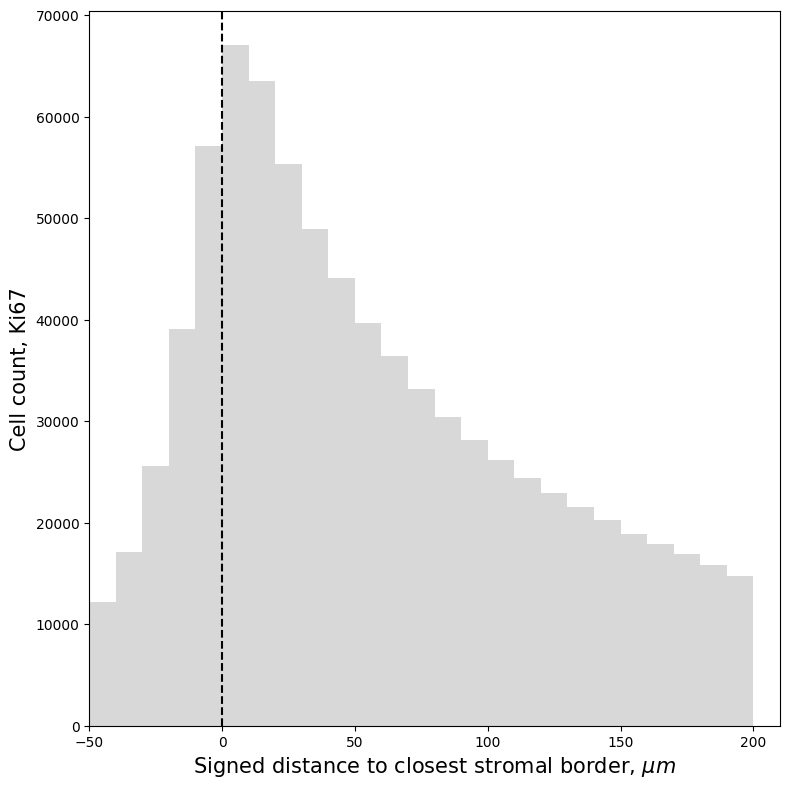

/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_46136/2857899633.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_intensity_1 = ker_pndrg_data.groupby(distance_bins_1)['pNDRG1_647: Cell: Median'].median()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_46136/2857899633.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_error_1 = ker_pndrg_data.groupby(distance_bins_1)['pNDRG1_647: Cell: Median'].sem()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_46136/2857899633.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in

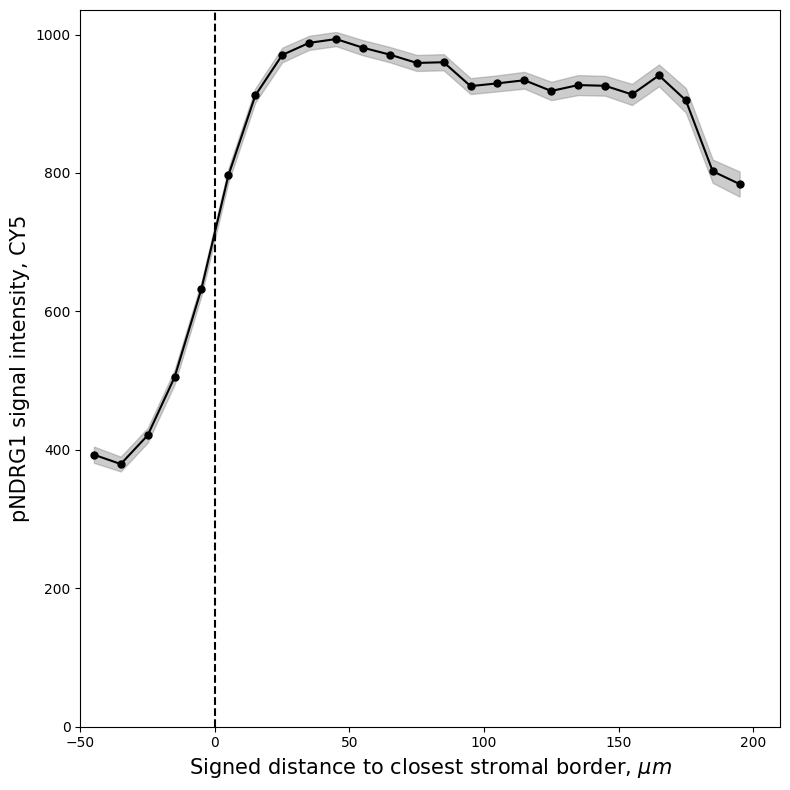

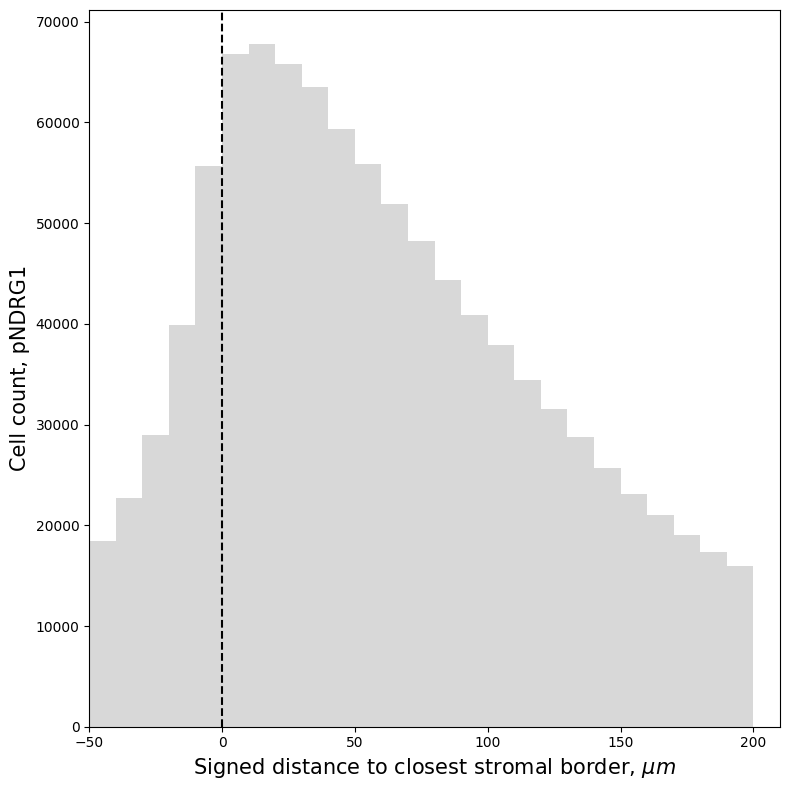

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define bin size and create distance bins for the first set of data
bin_size = 10
min_dist = -50
max_dist = 210

output_path = "/Users/antoine/Harvard/IAC/NinaKozlova/Submission/Preliminary/spatial_plots/8x8"

# Distance bins and calculations for the first set of data
distance_bins_1 = pd.cut(control_ker488_ki67['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
median_intensity_1 = control_ker488_ki67.groupby(distance_bins_1)['KI67_647: Nucleus: Median'].median()
std_error_1 = control_ker488_ki67.groupby(distance_bins_1)['KI67_647: Nucleus: Median'].sem()
bin_midpoints_1 = [(bin.left + bin.right) / 2 for bin in distance_bins_1.cat.categories]
num_data_points_1 = control_ker488_ki67.groupby(distance_bins_1).size()

# Distance bins and calculations for the second set of data
distance_bins_2 = pd.cut(control_ker488['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
median_intensity_2 = control_ker488.groupby(distance_bins_2)['KI67_647: Nucleus: Median'].median()
std_error_2 = control_ker488.groupby(distance_bins_2)['KI67_647: Nucleus: Median'].sem()
bin_midpoints_2 = [(bin.left + bin.right) / 2 for bin in distance_bins_2.cat.categories]
num_data_points_2 = control_ker488.groupby(distance_bins_2).size()

# Combine the data from both groups
combined_count = num_data_points_1.values + num_data_points_2.values

# Calculate the difference between the two median intensities
diff_line = median_intensity_1.values - median_intensity_2.values
# Calculate the combined standard error
diff_std = np.sqrt(std_error_1**2 + std_error_2**2)

plt.figure(figsize=(8, 8))
plt.xlim([min_dist, max_dist])
plt.ylabel(r'Ki67 signal intensity, CY5', color='black', fontsize=15)
plt.axvline(x=0, ls='--', color='black')
plt.fill_between(bin_midpoints_1, diff_line - diff_std, diff_line + diff_std, color='grey', alpha=0.4)
plt.errorbar(bin_midpoints_1, diff_line, color='black', linestyle='-', marker='o', markersize=5, alpha=1)
plt.ylim([0, None])
plt.xlabel(r'Signed distance to closest stromal border, $µm$', color='black', fontsize=15)
plt.tight_layout()
plt.savefig(f"{output_path}/spatial_SW1990_shC_Ki67", dpi=300, transparent=True)
plt.show()
plt.close()

plt.figure(figsize=(8, 8))
plt.xlim([min_dist, max_dist])
plt.ylabel(r'Cell count, Ki67', color='black', fontsize=15)
plt.axvline(x=0, ls='--', color='black')
plt.bar(bin_midpoints_1, combined_count, color='grey', width=bin_size, align='center', alpha=0.3, label='Ki67+') # color='#f781bf'
# plt.bar(bin_midpoints_2, num_data_points_2.values, color='#377eb8', width=bin_size, align='center', alpha=0.3, label='Ki67-')
plt.ylim([0, None])
plt.xlabel(r'Signed distance to closest stromal border, $µm$', color='black', fontsize=15)
plt.tight_layout()
plt.savefig(f"{output_path}/cell_count_SW1990_shC_Ki67", dpi=300, transparent=True)
plt.show()
plt.close()

# Distance bins and calculations for the third set of data
distance_bins_1 = pd.cut(ker_pndrg_data['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
median_intensity_1 = ker_pndrg_data.groupby(distance_bins_1)['pNDRG1_647: Cell: Median'].median()
std_error_1 = ker_pndrg_data.groupby(distance_bins_1)['pNDRG1_647: Cell: Median'].sem()
bin_midpoints_1 = [(bin.left + bin.right) / 2 for bin in distance_bins_1.cat.categories]
num_data_points_1 = ker_pndrg_data.groupby(distance_bins_1).size()

# Distance bins and calculations for the fourth set of data
distance_bins_2 = pd.cut(ker_data['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
median_intensity_2 = ker_data.groupby(distance_bins_2)['pNDRG1_647: Cell: Median'].median()
std_error_2 = ker_data.groupby(distance_bins_2)['pNDRG1_647: Cell: Median'].sem()
bin_midpoints_2 = [(bin.left + bin.right) / 2 for bin in distance_bins_2.cat.categories]
num_data_points_2 = ker_data.groupby(distance_bins_2).size()

# Combine the data from both groups
combined_count = num_data_points_1.values + num_data_points_2.values

# Calculate the difference between the two median intensities
diff_line = median_intensity_1.values - median_intensity_2.values
# Calculate the combined standard error
diff_std = np.sqrt(std_error_1**2 + std_error_2**2)

plt.figure(figsize=(8, 8))
plt.xlim([min_dist, max_dist])
plt.ylabel(r'pNDRG1 signal intensity, CY5', color='black', fontsize=15)
plt.axvline(x=0, ls='--', color='black')
plt.fill_between(bin_midpoints_1, diff_line - diff_std, diff_line + diff_std, color='gray', alpha=0.4)
plt.errorbar(bin_midpoints_1, diff_line, color='black', linestyle='-', marker='o', markersize=5, alpha=1)
plt.ylim([0, None])
plt.xlabel(r'Signed distance to closest stromal border, $µm$', color='black', fontsize=15)
plt.tight_layout()
plt.savefig(f"{output_path}/spatial_SW1990_shC_pNDRG1", dpi=300, transparent=True)
plt.show()
plt.close()

plt.figure(figsize=(8, 8))
plt.xlim([min_dist, max_dist])
plt.ylabel(r'Cell count, pNDRG1', color='black', fontsize=15)
plt.axvline(x=0, ls='--', color='black')
plt.bar(bin_midpoints_1, combined_count, color='grey', width=bin_size, align='center', alpha=0.3, label='Ki67+') # color='#f781bf',
#plt.bar(bin_midpoints_2, num_data_points_2.values, color='#377eb8', width=bin_size, align='center', alpha=0.3, label='Ki67-')
plt.ylim([0, None])
plt.xlabel(r'Signed distance to closest stromal border, $µm$', color='black', fontsize=15)
plt.tight_layout()
plt.savefig(f"{output_path}/cell_count_SW1990_shC_pNDRG1", dpi=300, transparent=True)
plt.show()
plt.close()

## Number of cells

In [5]:
# Ki67
numb_cell1 = control_ker488_ki67[(control_ker488_ki67['Signed distance to annotation Stroma µm'] >= -50) & (control_ker488_ki67['Signed distance to annotation Stroma µm'] <= 200)].size
numb_cell2 = control_ker488['Signed distance to annotation Stroma µm'].size
print(numb_cell1 + numb_cell2)


1611454


In [32]:
# pNDRG1
numb_cell1 = ker_pndrg_data[(ker_pndrg_data['Signed distance to annotation Stroma µm'] >= -50) & (ker_pndrg_data['Signed distance to annotation Stroma µm'] <= 200)].size
numb_cell2 = ker_data['Signed distance to annotation Stroma µm'].size
print(numb_cell1 + numb_cell2)


3376558


## Overlay signal intensity and cell count

### Ki67

/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_67807/4253564973.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_intensity_1 = control_ker488_ki67.groupby(distance_bins_1)['KI67_647: Nucleus: Median'].median()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_67807/4253564973.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_error_1 = control_ker488_ki67.groupby(distance_bins_1)['KI67_647: Nucleus: Median'].sem()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_67807/4253564973.py:19: FutureWarning: The default of observed=False is deprecated and will be change

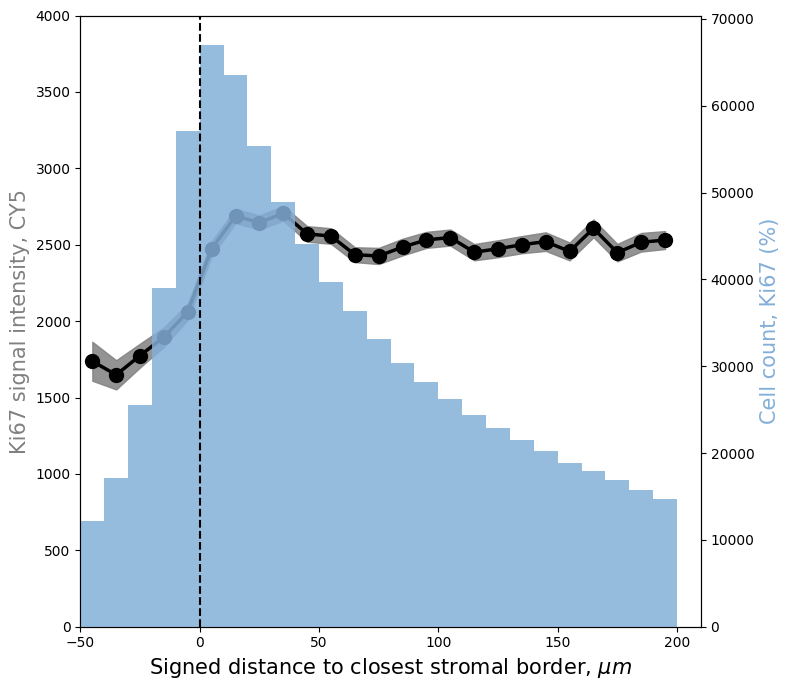

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define bin size and create distance bins for the first set of data
bin_size = 10
min_dist = -50
max_dist = 210

# Ki67

output_path = "/Users/antoine/Harvard/IAC/NinaKozlova/Submission/Preliminary/spatial_plots/8x8"

# Distance bins and calculations for the first set of data
distance_bins_1 = pd.cut(control_ker488_ki67['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
median_intensity_1 = control_ker488_ki67.groupby(distance_bins_1)['KI67_647: Nucleus: Median'].median()
std_error_1 = control_ker488_ki67.groupby(distance_bins_1)['KI67_647: Nucleus: Median'].sem()
bin_midpoints_1 = [(bin.left + bin.right) / 2 for bin in distance_bins_1.cat.categories]
num_data_points_1 = control_ker488_ki67.groupby(distance_bins_1).size()

# Distance bins and calculations for the second set of data
distance_bins_2 = pd.cut(control_ker488['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
median_intensity_2 = control_ker488.groupby(distance_bins_2)['KI67_647: Nucleus: Median'].median()
std_error_2 = control_ker488.groupby(distance_bins_2)['KI67_647: Nucleus: Median'].sem()
bin_midpoints_2 = [(bin.left + bin.right) / 2 for bin in distance_bins_2.cat.categories]
num_data_points_2 = control_ker488.groupby(distance_bins_2).size()

# Combine the data from both groups
combined_count = num_data_points_1.values + num_data_points_2.values

# Calculate the difference between the two median intensities
diff_line = median_intensity_1.values - median_intensity_2.values
# Calculate the combined standard error
diff_std = np.sqrt(std_error_1**2 + std_error_2**2)

# plotting
fig, ax1 = plt.subplots(figsize=(8, 7))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same y-axis
color = '#83AFD8'  # Change here#f781bf
ax2.set_ylabel('Cell count, Ki67 (%)', color=color, fontsize=15)  # we already handled the x-label with ax1
ax2.bar(bin_midpoints_1, combined_count, color=color, width=bin_size, align='center', alpha=0.85, label='Ki67+') # color='#f781bf'
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_xlim(ax1.get_xlim())

color = '#808080'  # Change here
ax1.set_ylabel('Ki67 signal intensity, CY5', color=color, fontsize=15)
ax1.fill_between(bin_midpoints_1, diff_line - diff_std, diff_line + diff_std, color=color, alpha=0.85)
ax1.errorbar(bin_midpoints_1, diff_line, color='black', linestyle='-', marker='o', markersize=10, alpha=1, linewidth=2.5)
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim([0, 4000])

ax1.set_xlabel(r'Signed distance to closest stromal border, $µm$', color='black', fontsize=15)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.axvline(x=0, ls='--', color='black')
plt.xlim([min_dist, max_dist])
plt.savefig(f"{output_path}/combined_plot_Ki67_twiny_percentage", dpi=300, transparent=True)
plt.tight_layout()
plt.show()
plt.close()

/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_67807/4030911804.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_intensity_1 = control_ker488_ki67.groupby(distance_bins_1)['KI67_647: Nucleus: Median'].median()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_67807/4030911804.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_error_1 = control_ker488_ki67.groupby(distance_bins_1)['KI67_647: Nucleus: Median'].sem()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_67807/4030911804.py:17: FutureWarning: The default of observed=False is deprecated and will be change

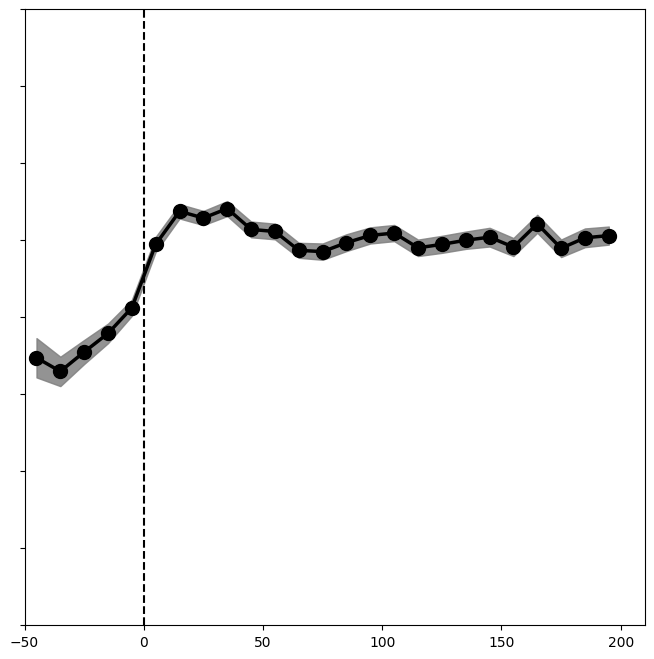

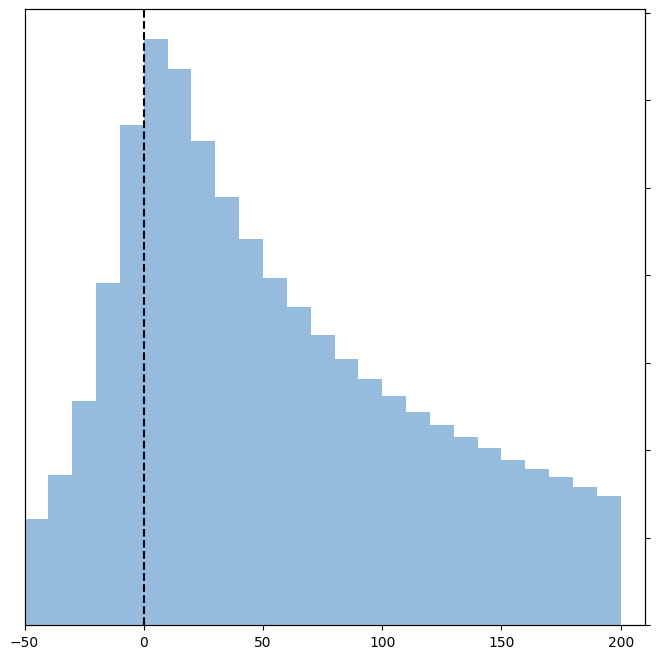

In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define bin size and create distance bins for the first set of data
bin_size = 10
min_dist = -50
max_dist = 210

output_path = "/Users/antoine/Harvard/IAC/NinaKozlova/Submission/Preliminary/spatial_plots/8x8"

# Distance bins and calculations for the first set of data
distance_bins_1 = pd.cut(control_ker488_ki67['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
median_intensity_1 = control_ker488_ki67.groupby(distance_bins_1)['KI67_647: Nucleus: Median'].median()
std_error_1 = control_ker488_ki67.groupby(distance_bins_1)['KI67_647: Nucleus: Median'].sem()
bin_midpoints_1 = [(bin.left + bin.right) / 2 for bin in distance_bins_1.cat.categories]
num_data_points_1 = control_ker488_ki67.groupby(distance_bins_1).size()

# Distance bins and calculations for the second set of data
distance_bins_2 = pd.cut(control_ker488['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
median_intensity_2 = control_ker488.groupby(distance_bins_2)['KI67_647: Nucleus: Median'].median()
std_error_2 = control_ker488.groupby(distance_bins_2)['KI67_647: Nucleus: Median'].sem()
bin_midpoints_2 = [(bin.left + bin.right) / 2 for bin in distance_bins_2.cat.categories]
num_data_points_2 = control_ker488.groupby(distance_bins_2).size()

# Combine the data from both groups
combined_count = num_data_points_1.values + num_data_points_2.values

# Calculate the difference between the two median intensities
diff_line = median_intensity_1.values - median_intensity_2.values
# Calculate the combined standard error
diff_std = np.sqrt(std_error_1**2 + std_error_2**2)

# plotting
fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.tick_params(axis='y', which='both', labelleft=False)
color = '#808080'  # Change here
#ax1.set_ylabel('Ki67 signal intensity, CY5', color=color, fontsize=15)
ax1.fill_between(bin_midpoints_1, diff_line - diff_std, diff_line + diff_std, color=color, alpha=0.85)
ax1.errorbar(bin_midpoints_1, diff_line, color='black', linestyle='-', marker='o', markersize=10, alpha=1, linewidth=2.5)
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim([0, 4000])
#ax1.set_xlabel(r'Signed distance to closest stromal border, $µm$', color='black', fontsize=15)
plt.axvline(x=0, ls='--', color='black')
plt.xlim([min_dist, max_dist])
plt.savefig(f"{output_path}/Ki67_signal_without_axis_labels", dpi=300, transparent=True)
plt.show()
plt.close()

fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()
ax1.tick_params(axis='y', which='both', left=False, labelleft=False)
ax2.tick_params(axis='y', which='both', labelright=False)

color = '#83AFD8'  # Change here#f781bf
#ax2.set_ylabel('Cell count, Ki67 (%)', color=color, fontsize=15)  # we already handled the x-label with ax1
ax2.bar(bin_midpoints_1, combined_count, color=color, width=bin_size, align='center', alpha=0.85, label='Ki67+') # color='#f781bf'
#ax2.tick_params(axis='y', labelcolor='black')
ax2.set_xlim(ax1.get_xlim())

#ax2.set_xlabel(r'Signed distance to closest stromal border, $µm$', color='black', fontsize=15)
plt.axvline(x=0, ls='--', color='black')
plt.xlim([min_dist, max_dist])
plt.savefig(f"{output_path}/Ki67_cell_count_without_axis_labels", dpi=300, transparent=True)
plt.show()
plt.close()


/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_67807/2368685115.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_intensity_1 = control_ker488_ki67.groupby(distance_bins_1)['KI67_647: Nucleus: Median'].median()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_67807/2368685115.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_error_1 = control_ker488_ki67.groupby(distance_bins_1)['KI67_647: Nucleus: Median'].sem()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_67807/2368685115.py:17: FutureWarning: The default of observed=False is deprecated and will be change

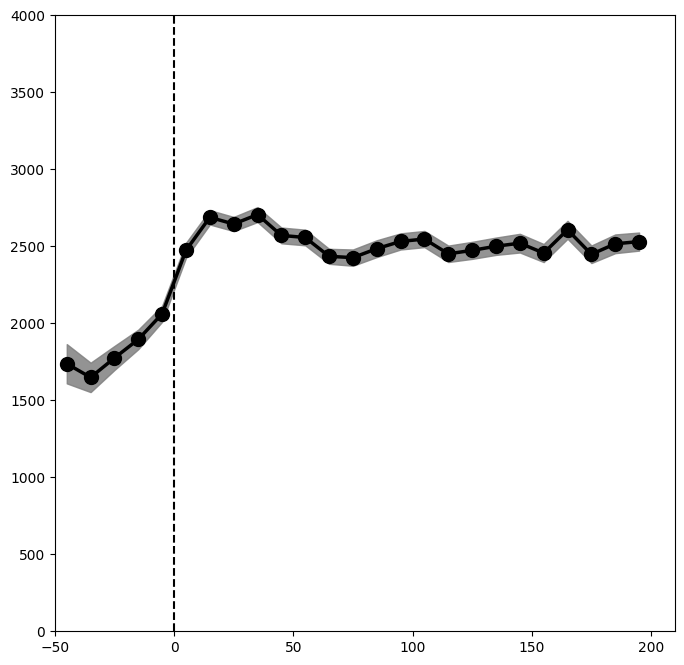

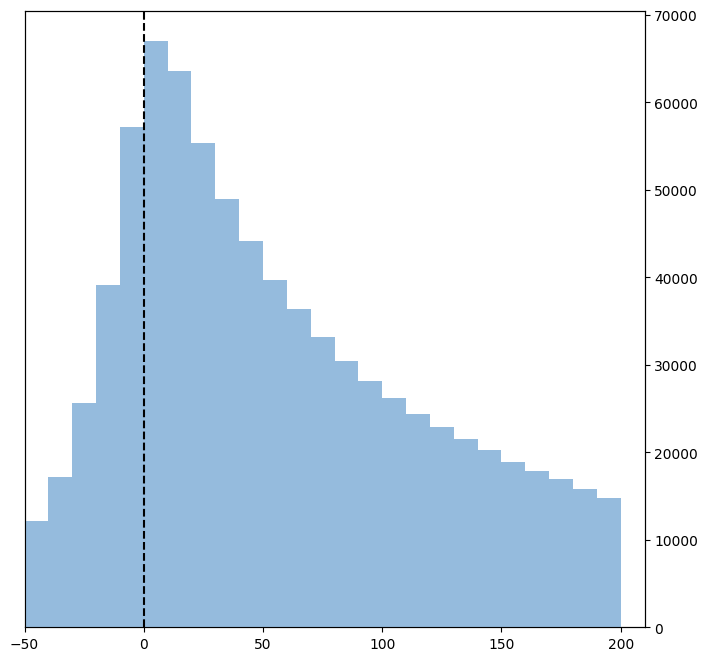

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define bin size and create distance bins for the first set of data
bin_size = 10
min_dist = -50
max_dist = 210

output_path = "/Users/antoine/Harvard/IAC/NinaKozlova/Submission/Preliminary/spatial_plots/8x8"

# Distance bins and calculations for the first set of data
distance_bins_1 = pd.cut(control_ker488_ki67['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
median_intensity_1 = control_ker488_ki67.groupby(distance_bins_1)['KI67_647: Nucleus: Median'].median()
std_error_1 = control_ker488_ki67.groupby(distance_bins_1)['KI67_647: Nucleus: Median'].sem()
bin_midpoints_1 = [(bin.left + bin.right) / 2 for bin in distance_bins_1.cat.categories]
num_data_points_1 = control_ker488_ki67.groupby(distance_bins_1).size()

# Distance bins and calculations for the second set of data
distance_bins_2 = pd.cut(control_ker488['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
median_intensity_2 = control_ker488.groupby(distance_bins_2)['KI67_647: Nucleus: Median'].median()
std_error_2 = control_ker488.groupby(distance_bins_2)['KI67_647: Nucleus: Median'].sem()
bin_midpoints_2 = [(bin.left + bin.right) / 2 for bin in distance_bins_2.cat.categories]
num_data_points_2 = control_ker488.groupby(distance_bins_2).size()

# Combine the data from both groups
combined_count = num_data_points_1.values + num_data_points_2.values

# Calculate the difference between the two median intensities
diff_line = median_intensity_1.values - median_intensity_2.values
# Calculate the combined standard error
diff_std = np.sqrt(std_error_1**2 + std_error_2**2)

# plotting
fig, ax1 = plt.subplots(figsize=(8, 8))
color = '#808080'  # Change here
#ax1.set_ylabel('Ki67 signal intensity, CY5', color=color, fontsize=15)
ax1.fill_between(bin_midpoints_1, diff_line - diff_std, diff_line + diff_std, color=color, alpha=0.85)
ax1.errorbar(bin_midpoints_1, diff_line, color='black', linestyle='-', marker='o', markersize=10, alpha=1, linewidth=2.5)
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim([0, 4000])
#ax1.set_xlabel(r'Signed distance to closest stromal border, $µm$', color='black', fontsize=15)
plt.axvline(x=0, ls='--', color='black')
plt.xlim([min_dist, max_dist])
plt.savefig(f"{output_path}/Ki67_signal_with_axis_labels", dpi=300, transparent=True)
plt.show()
plt.close()

fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()
ax1.tick_params(axis='y', which='both', left=False, labelleft=False)
#ax2.tick_params(axis='y', which='both', labelright=False)

color = '#83AFD8'  # Change here#f781bf
#ax2.set_ylabel('Cell count, Ki67 (%)', color=color, fontsize=15)  # we already handled the x-label with ax1
ax2.bar(bin_midpoints_1, combined_count, color=color, width=bin_size, align='center', alpha=0.85, label='Ki67+') # color='#f781bf'
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_xlim(ax1.get_xlim())

#ax2.set_xlabel(r'Signed distance to closest stromal border, $µm$', color='black', fontsize=15)
plt.axvline(x=0, ls='--', color='black')
plt.xlim([min_dist, max_dist])
plt.savefig(f"{output_path}/Ki67_cell_count_with_axis_labels", dpi=300, transparent=True)
plt.show()
plt.close()


### pNDRG1

/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_84411/1011504479.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_intensity_1 = ker_pndrg_data.groupby(distance_bins_1)['pNDRG1_647: Cell: Max'].median()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_84411/1011504479.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_error_1 = ker_pndrg_data.groupby(distance_bins_1)['pNDRG1_647: Cell: Max'].sem()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_84411/1011504479.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a futur

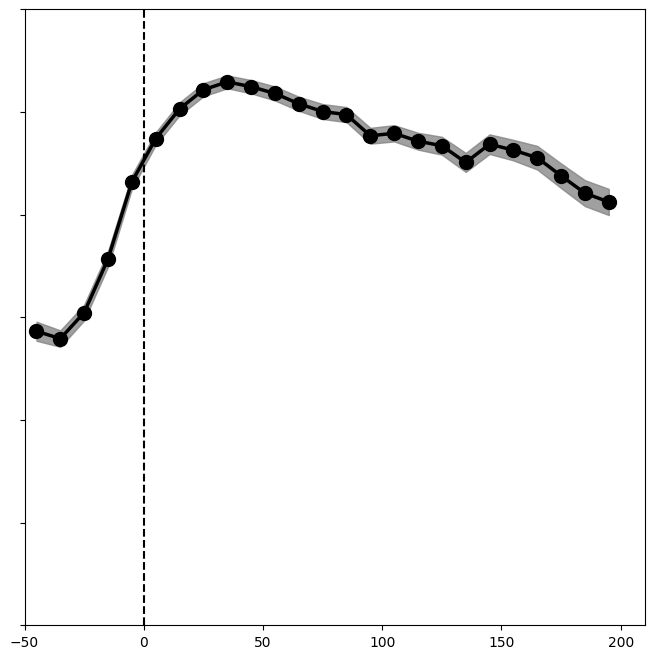

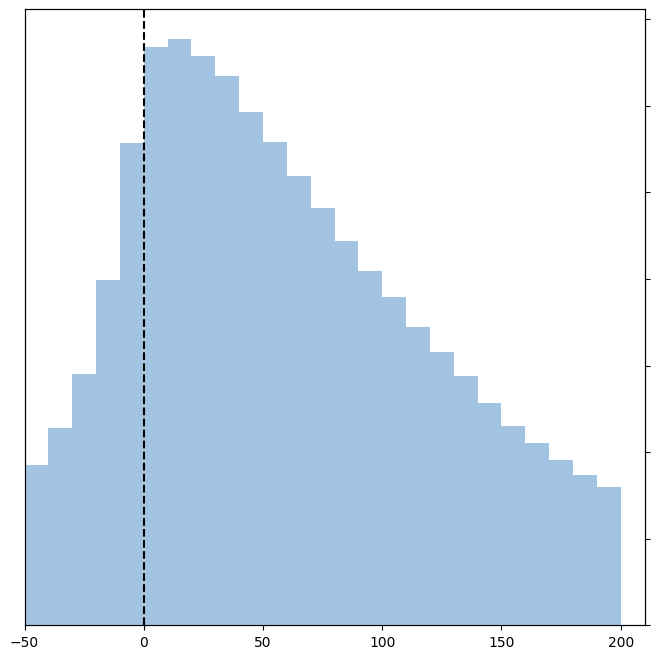

In [8]:
# Define bin size and create distance bins for the first set of data
bin_size = 10
min_dist = -50
max_dist = 210

# Distance bins and calculations for the third set of data
distance_bins_1 = pd.cut(ker_pndrg_data['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
median_intensity_1 = ker_pndrg_data.groupby(distance_bins_1)['pNDRG1_647: Cell: Max'].median()
std_error_1 = ker_pndrg_data.groupby(distance_bins_1)['pNDRG1_647: Cell: Max'].sem()
bin_midpoints_1 = [(bin.left + bin.right) / 2 for bin in distance_bins_1.cat.categories]
num_data_points_1 = ker_pndrg_data.groupby(distance_bins_1).size()

# Distance bins and calculations for the fourth set of data
distance_bins_2 = pd.cut(ker_data['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
median_intensity_2 = ker_data.groupby(distance_bins_2)['pNDRG1_647: Cell: Max'].median()
std_error_2 = ker_data.groupby(distance_bins_2)['pNDRG1_647: Cell: Max'].sem()
bin_midpoints_2 = [(bin.left + bin.right) / 2 for bin in distance_bins_2.cat.categories]
num_data_points_2 = ker_data.groupby(distance_bins_2).size()

# Combine the data from both groups
combined_count = num_data_points_1.values + num_data_points_2.values

# Calculate the difference between the two median intensities
diff_line = median_intensity_1.values - median_intensity_2.values
# Calculate the combined standard error
diff_std = np.sqrt((std_error_1)**2 + (std_error_2)**2)

color = "#83AFD8"

# plotting
fig, ax1 = plt.subplots(figsize=(8, 8))

# Calculate the aspect ratio based on the data limits
x_min, x_max = min_dist, max_dist
y_min, y_max = 0, 3000

# Plot the data
ax1.fill_between(bin_midpoints_1, diff_line - diff_std, diff_line + diff_std, color="grey", alpha=0.75)
ax1.errorbar(bin_midpoints_1, diff_line, color='black', linestyle='-', marker='o', markersize=10, alpha=1, linewidth=2.5)
ax1.tick_params(axis='y', which='both', labelleft=False, labelright=False)

# Adjust other plot settings as needed
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xlim([x_min, x_max])
ax1.set_ylim([y_min, y_max])
plt.axvline(x=0, ls='--', color='black')
# Save and display the plot
#plt.savefig(f"{output_path}/pNDRG1_signal_without_axis_labels", dpi=300, transparent=True)
plt.show()
plt.close()

# plotting
fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()
ax1.tick_params(axis='y', which='both', left=False, labelleft=False, labelright=False)

# Plot data on ax2
ax2.bar(bin_midpoints_1, combined_count, color=color, width=bin_size, align='center', alpha=0.75, label='Ki67+')
ax2.tick_params(axis='y', labelcolor='black', left=False, labelleft=False, labelright=False)
ax2.set_xlim(ax1.get_xlim())

# Adjust other plot settings as needed
ax2.set_xlabel(r'Signed distance to closest stromal border, $µm$', color='black', fontsize=15)
plt.axvline(x=0, ls='--', color='black')
plt.xlim([min_dist, max_dist])

# Save and display the plot
#plt.savefig(f"{output_path}/pNDRG1_cell_count_without_axis_labels", dpi=300, transparent=True)
plt.show()
plt.close()

/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_67807/3989936302.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_intensity_1 = ker_pndrg_data.groupby(distance_bins_1)['pNDRG1_647: Cell: Median'].median()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_67807/3989936302.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_error_1 = ker_pndrg_data.groupby(distance_bins_1)['pNDRG1_647: Cell: Median'].sem()
/var/folders/3b/6sb_mkrj5jz7x94kf6pw1vmw0000gq/T/ipykernel_67807/3989936302.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a 

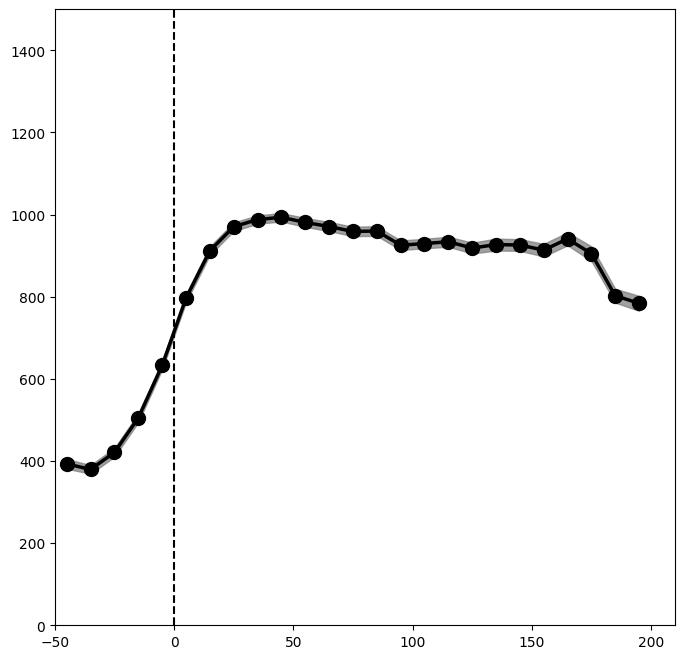

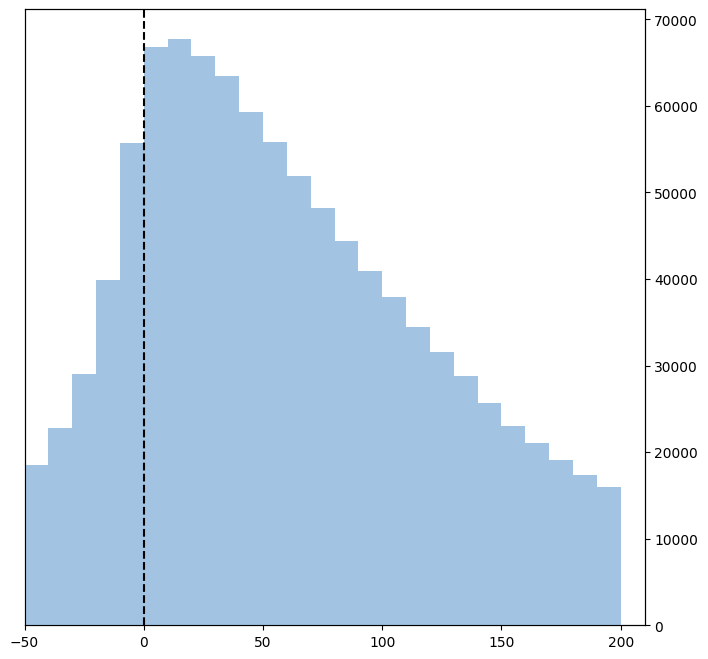

In [209]:
# Distance bins and calculations for the third set of data
distance_bins_1 = pd.cut(ker_pndrg_data['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
median_intensity_1 = ker_pndrg_data.groupby(distance_bins_1)['pNDRG1_647: Cell: Median'].median()
std_error_1 = ker_pndrg_data.groupby(distance_bins_1)['pNDRG1_647: Cell: Median'].sem()
bin_midpoints_1 = [(bin.left + bin.right) / 2 for bin in distance_bins_1.cat.categories]
num_data_points_1 = ker_pndrg_data.groupby(distance_bins_1).size()

# Distance bins and calculations for the fourth set of data
distance_bins_2 = pd.cut(ker_data['Signed distance to annotation Stroma µm'], bins=range(min_dist, max_dist, bin_size), right=False)
median_intensity_2 = ker_data.groupby(distance_bins_2)['pNDRG1_647: Cell: Median'].median()
std_error_2 = ker_data.groupby(distance_bins_2)['pNDRG1_647: Cell: Median'].sem()
bin_midpoints_2 = [(bin.left + bin.right) / 2 for bin in distance_bins_2.cat.categories]
num_data_points_2 = ker_data.groupby(distance_bins_2).size()

# Combine the data from both groups
combined_count = num_data_points_1.values + num_data_points_2.values

# Calculate the difference between the two median intensities
diff_line = median_intensity_1.values - median_intensity_2.values
# Calculate the combined standard error
diff_std = np.sqrt((std_error_1)**2 + (std_error_2)**2)

color = "#83AFD8"

# plotting
fig, ax1 = plt.subplots(figsize=(8, 8))

# Calculate the aspect ratio based on the data limits
x_min, x_max = min_dist, max_dist
y_min, y_max = 0, 1500

# Plot the data
ax1.fill_between(bin_midpoints_1, diff_line - diff_std, diff_line + diff_std, color="grey", alpha=0.75)
ax1.errorbar(bin_midpoints_1, diff_line, color='black', linestyle='-', marker='o', markersize=10, alpha=1, linewidth=2.5)
ax1.tick_params(axis='y', which='both', labelright=False)

# Adjust other plot settings as needed
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xlim([x_min, x_max])
ax1.set_ylim([y_min, y_max])
plt.axvline(x=0, ls='--', color='black')
# Save and display the plot
plt.savefig(f"{output_path}/pNDRG1_signal_with_axis_labels", dpi=300, transparent=True)
plt.show()
plt.close()

# plotting
fig, ax1 = plt.subplots(figsize=(8, 8))
ax2 = ax1.twinx()
ax1.tick_params(axis='y', which='both', left=False, labelleft=False)

# Plot data on ax2
ax2.bar(bin_midpoints_1, combined_count, color=color, width=bin_size, align='center', alpha=0.75, label='Ki67+')
ax2.tick_params(axis='y', labelcolor='black', left=False, labelleft=False)
ax2.set_xlim(ax1.get_xlim())

# Adjust other plot settings as needed
ax2.set_xlabel(r'Signed distance to closest stromal border, $µm$', color='black', fontsize=15)
plt.axvline(x=0, ls='--', color='black')
plt.xlim([min_dist, max_dist])

# Save and display the plot
plt.savefig(f"{output_path}/pNDRG1_cell_count_with_axis_labels", dpi=300, transparent=True)
plt.show()
plt.close()